In [1]:
'''
Editor: @Hyunhomo
Reference: https://github.com/TobiasGlaubach/python-ml-turbofan
'''

## Import libraries in python
import os
import pandas as pd
import padasip as pa
# pa.filters.FilterRLS(n)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

import scipy.stats as stats
from scipy.stats import ttest_1samp

In [2]:

### Data load (use only FD001 first)
## Assign columns name
cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
col_rul = ['RUL_truth']


## Read csv file to pandas dataframe
train_FD001 = pd.read_csv('CMAPSSData/train_FD001.txt', sep= ' ', header=None, 
                          names=cols, index_col=False)
test_FD001 = pd.read_csv('CMAPSSData/test_FD001.txt', sep= ' ', header=None, 
                          names=cols, index_col=False)
RUL_FD001 = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep= ' ', header=None, 
                          names=col_rul, index_col=False)

## Calculate RUL and append to train data
# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in train_FD001['unit_nr'].unique():
    mapper[unit_nr] = train_FD001['cycles'].loc[train_FD001['unit_nr'] == unit_nr].max()
    
# calculate RUL = time.max() - time_now for each unit
train_FD001['RUL'] = train_FD001['unit_nr'].apply(lambda nr: mapper[nr]) - train_FD001['cycles']


## Excluse columns which only have NaN as value
# nan_cols = ['sensor_{0:02d}'.format(s + 22) for s in range(5)]
cols_nan = train_FD001.columns[train_FD001.isna().any()].tolist()
print('Columns with all nan: \n' + str(cols_nan) + '\n')
cols_const = [ col for col in train_FD001.columns if len(train_FD001[col].unique()) <= 2 ]
print('Columns with all const values: \n' + str(cols_const) + '\n')


train_FD001 = train_FD001.drop(columns=cols_const + cols_nan)
test_FD001 = test_FD001.drop(columns=cols_const + cols_nan)

## Check loaded data
print (train_FD001)
print (test_FD001)
print (RUL_FD001)


Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

Columns with all const values: 
['os_3', 'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

       unit_nr  cycles    os_1    os_2  sensor_02  sensor_03  sensor_04  \
0            1       1 -0.0007 -0.0004     641.82    1589.70    1400.60   
1            1       2  0.0019 -0.0003     642.15    1591.82    1403.14   
2            1       3 -0.0043  0.0003     642.35    1587.99    1404.20   
3            1       4  0.0007  0.0000     642.35    1582.79    1401.87   
4            1       5 -0.0019 -0.0002     642.37    1582.85    1406.22   
...        ...     ...     ...     ...        ...        ...        ...   
20626      100     196 -0.0004 -0.0003     643.49    1597.98    1428.63   
20627      100     197 -0.0016 -0.0005     643.54    1604.50    1433.58   
20628      100     198  0.0004  0.000

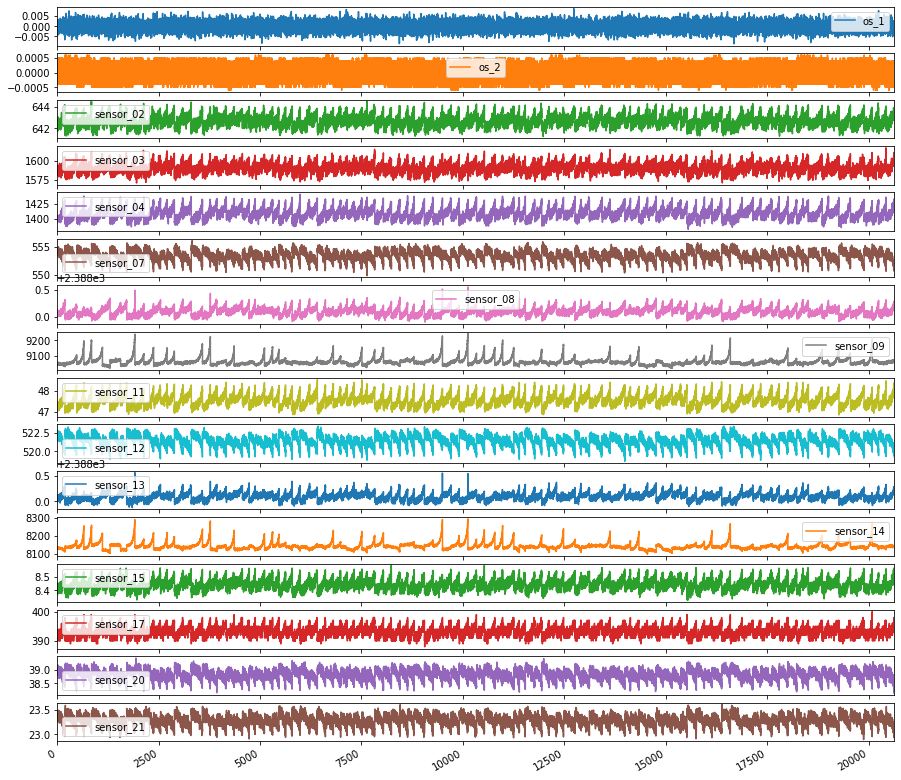

In [3]:
## Plot sensor measurements (time series data) / without normalization
cols_features = [c for c in train_FD001.columns if c.startswith('o') or c.startswith('s')]
t = pd.DataFrame(train_FD001[cols_features].values, columns=cols_features).plot(subplots=True, figsize=(15, 15))



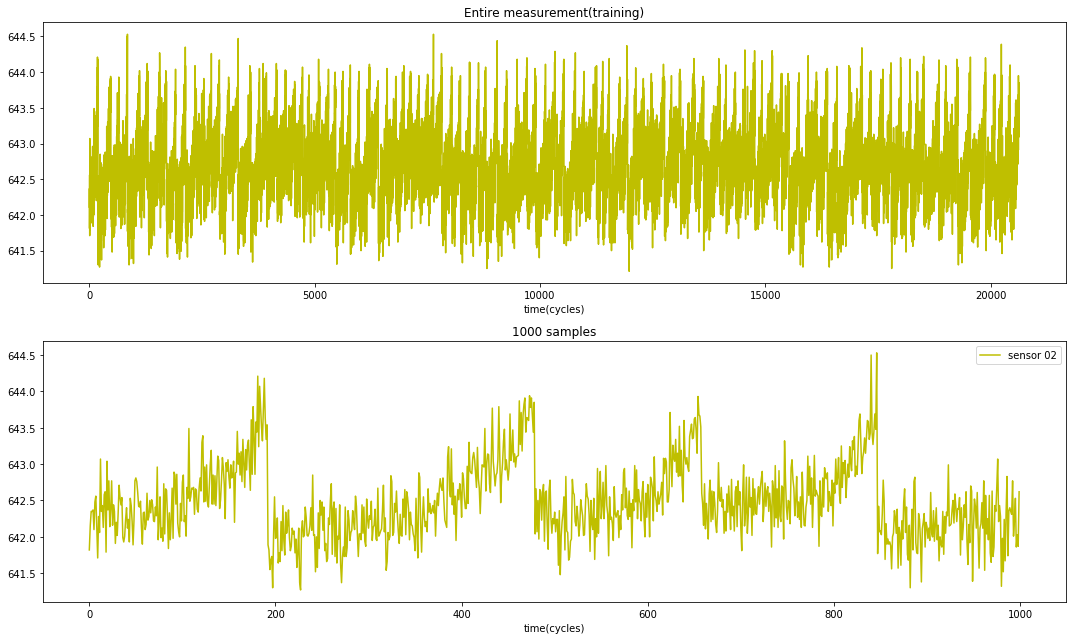

In [4]:
### Prediction error estimation (Anomaly score) with RLS
## Only consider sensor 02
# Assign a time series to numpy array
sensor_02_ts = train_FD001['sensor_02']

# show a time series
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Entire measurement(training)");plt.xlabel("time(cycles)")
plt.plot(sensor_02_ts,"y", label="sensor 02")
plt.subplot(212);plt.title("1000 samples");plt.xlabel("time(cycles)")
plt.plot(sensor_02_ts[:1000],"y", label="sensor 02")
plt.legend(); plt.tight_layout(); plt.show()


In [5]:
### function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
#     print ("data_matrix", data_matrix)
#     print (" data_matrix.shape",  data_matrix.shape)
#     print ("data_matrix.shape[0]", data_matrix.shape[0])
    num_elements = data_matrix.shape[0]
#     print ("num_elements", num_elements)
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements - seq_length - pred_length), range(seq_length, num_elements - pred_length)):
        yield data_matrix[start:stop, :]


        
def gen_target(id_df, seq_length, pred_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
#     print (" data_matrix.shape",  data_matrix.shape)
    num_elements = data_matrix.shape[0]

#     print ("num_elements", num_elements)
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(seq_length, num_elements  -pred_length), range(seq_length + pred_length , num_elements )):
        yield data_matrix[start:stop, :]
        
        
        
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements- pred_length, :]
        
        

In [6]:
### Define functions for anomaly detection (analysis of prediction errors)
'''

'''


def EWMA_Calc(epsilon, mu, lmbd_mu):
    """
    epsilon - input value for current time stamp (prediction error)
    mu - previous EWMA (average of until previous time stamp)
    lmbd_mu - a constant smoothing factor for EWMA weighting decrease
    """
    # calculation formula
    ewma = (lmbd_mu * epsilon) + ((1-lmbd_mu)*mu) 
    # return the result
    return ewma




def EWMA_Update(epsilon, anomaly, mu, sigma, lmbd_mu, lmbd_sigma):
    """
    epsilon - input value for current time stamp (prediction error)
    anomaly - True(1)/False(0) of anomaly until previous time stamp
    mu - previous EWMA (average of until previous time stamp)
    sigma - previous absolute deviation
    lmbd_mu - a constant smoothing factor for EWMA weighting decrease
    lmbd_sigma - a constant smoothing factor for the calculation of updating absolute deviation
    """
    if anomaly == True :
        # update absolute deviation(sigma) if there is no anomaly up to now
        sigma = EWMA_Calc ( abs(epsilon - mu), sigma , lmbd_sigma )
        
    # update EWMA 
    mu = EWMA_Calc( epsilon, mu, lmbd_mu )
    sigma = sigma
    # return mu and sigma, mu(average is always updated, 
    # but abs deviation is updated only when anomaly is False)
    
    return mu, sigma




def InitPhaseOne (epsilon, mu, sigma, lmbd_mu, lmbd_sigma, anomaly=False):
    """
    'initial phase to calculate/update average for the first few time stamps'
    
    """
    mu, sigma = EWMA_Update(epsilon, anomaly, mu, sigma, lmbd_mu, lmbd_sigma)
    
    return mu, sigma
    
     
    
    
def InitPhaseTwo (epsilon, mu, sigma, lmbd_mu, lmbd_sigma, thold_ad, anomaly=False):
    """
    'second phase of initialization to adapt threshold'
    thold_ad - threshold factor for the anomaly detection 
    
    """
    mu, sigma = EWMA_Update(epsilon, anomaly, mu, sigma, lmbd_mu, lmbd_sigma)    
    
    if abs(epsilon - mu) > sigma * thold_ad : 
        thold_ad = abs(epsilon - mu) / sigma
    
    
    return mu, sigma , thold_ad





def InitPhasePvalue (epsilon, mu, sigma, thold_p, conf_lv = 0.05):
    """
    'induce thold_p value to evaluate p-value in detection step'
    thold_p - threshold factor for the p-value
    conf_lv - user defined confidence level, 0.05 means 95%
    
    """       
    fixed_thold = stats.norm.ppf(conf_lv, loc = mu, scale = thold_p*sigma)
    deviation_thold = abs(fixed_thold - mu)
    
    # loop until thold_p shows can be enough variance in normal distribution    
    while abs(epsilon-mu)> deviation_thold :
        thold_p += 0.3        
        fixed_thold = stats.norm.ppf(conf_lv, loc = mu, scale = thold_p*sigma)
        deviation_thold = abs(fixed_thold - mu)
        
#         print ("bad loop- thold_p:%s, sigma:%s" %(thold_p,sigma))
        
    
    return thold_p



    
    
def Detection (epsilon, mu, sigma, lmbd_mu, lmbd_sigma, thold_ad, thold_p, anomaly=False):
    
    '''
    main function which detect anomaly and calculate p-value
    epsilon - current inpur prediction error
    anomaly - default is False, the detection result (True/False) will be return
    mu, sigma - updated average or deviation value during initalization phase
    lmbd_mu, lmbd_sigma - manually selected smoothing factor for EWMA calculation
    thold_ad, thold_p - adaptive threshold factor value, initial value is determined in inital phase
    
    '''
    
    if abs(epsilon - mu) > sigma * thold_ad : 
        anomaly = True
    
    
    mu, sigma = EWMA_Update(epsilon, anomaly, mu, sigma, lmbd_mu, lmbd_sigma)
    
    # half tailed p-value (only concerning deviation from the mean, range:[0,0.5])
    # if p_value is supposed to be used for anomaly detection, 
    # then anomaly is true when p_value is larger than conf_lv(user defined confidence level)  
    if epsilon > mu :
        p_value = stats.norm.sf(epsilon, mu, thold_p*sigma) #p-value right tailed (right hand side of mean)
    else :
        p_value = stats.norm.cdf(epsilon, mu, thold_p*sigma) #p-value left tailed (left hand side of mean)
#     print (p_value)

    
    return mu, sigma , anomaly, p_value



Initialized value of sensor 0 -  mu:[-0.08836942], signma:[0.23863457], thold_ad:[9.25869106], thold_p:11.200000000000005
no anomaly detected
Initialized value of sensor 1 -  mu:[-1.31808988], signma:[2.23046689], thold_ad:[14.50494229], thold_p:17.500000000000018
no anomaly detected
Initialized value of sensor 2 -  mu:[2.15174221], signma:[3.22152866], thold_ad:[6.89688745], thold_p:8.199999999999998


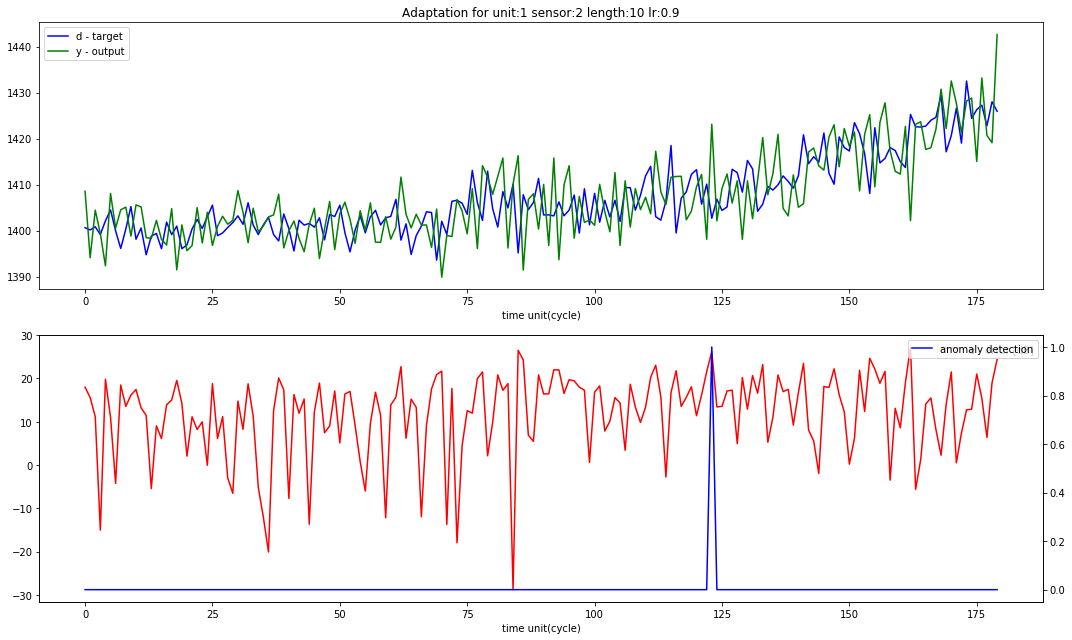

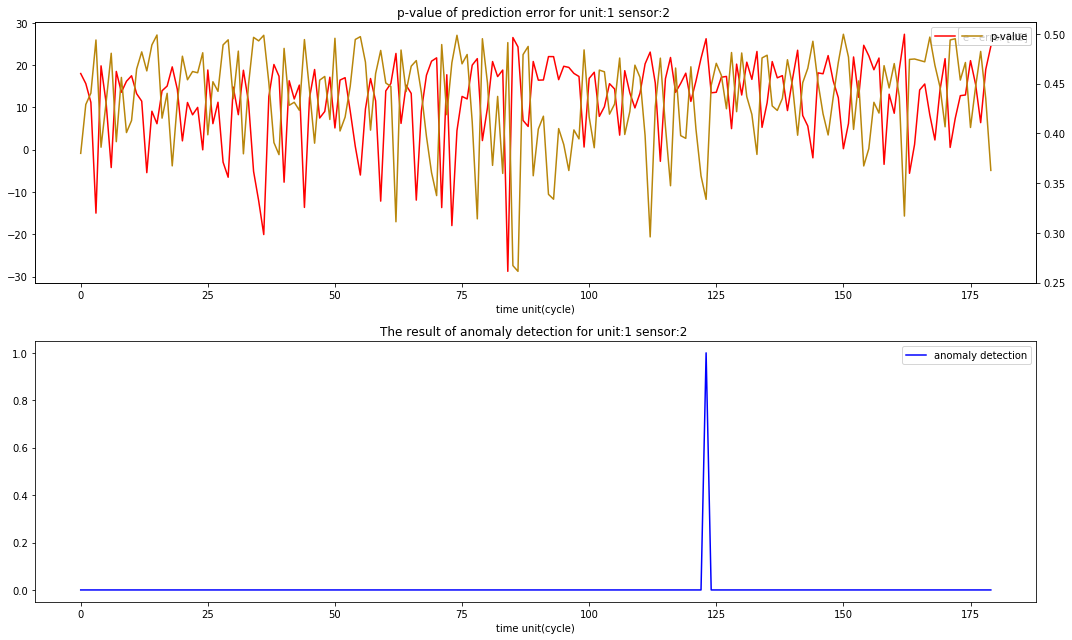

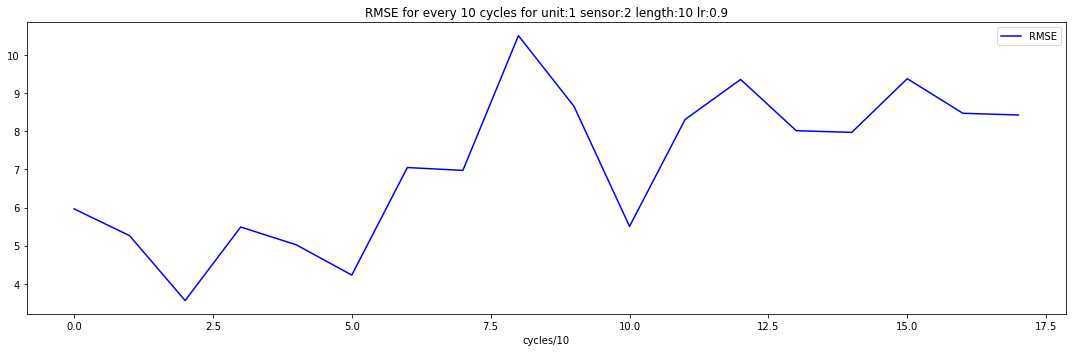

Initialized value of sensor 3 -  mu:[0.23932214], signma:[1.04482608], thold_ad:[2.75235085], thold_p:3.3999999999999995


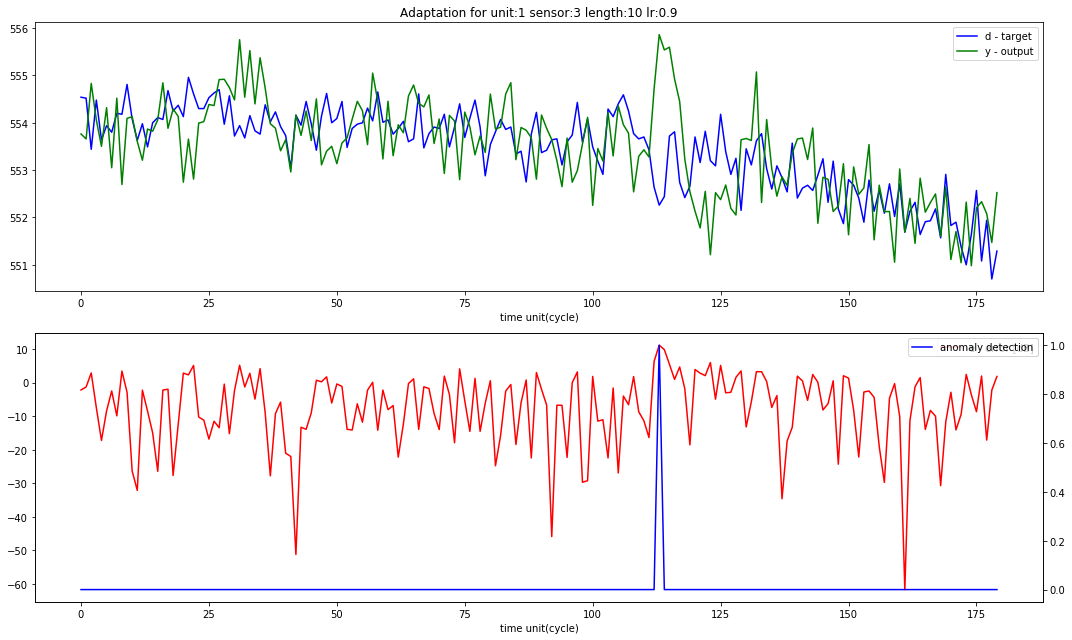

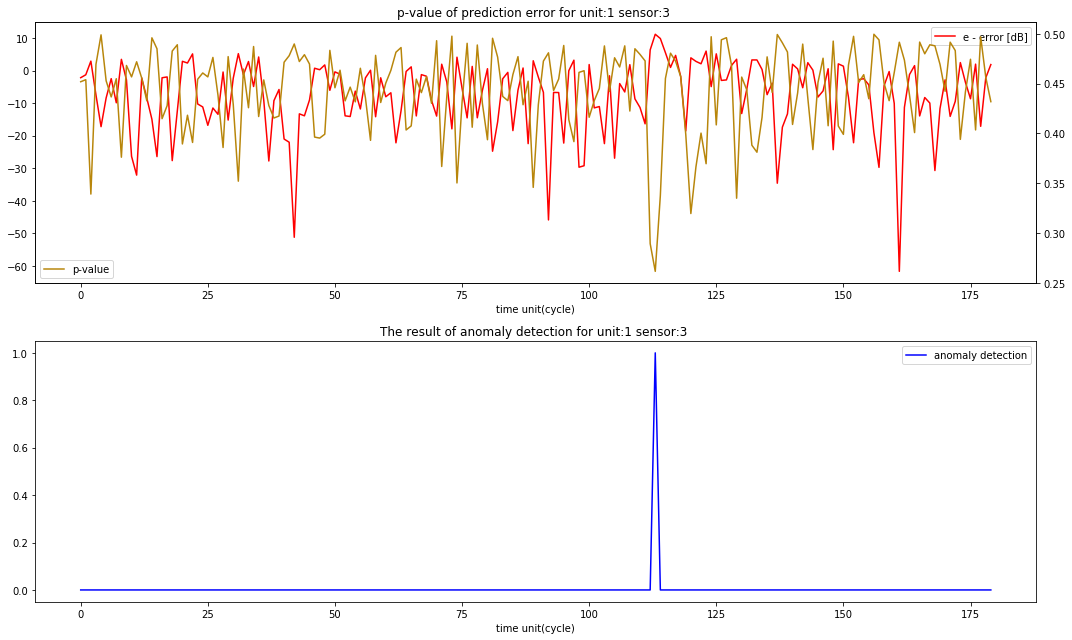

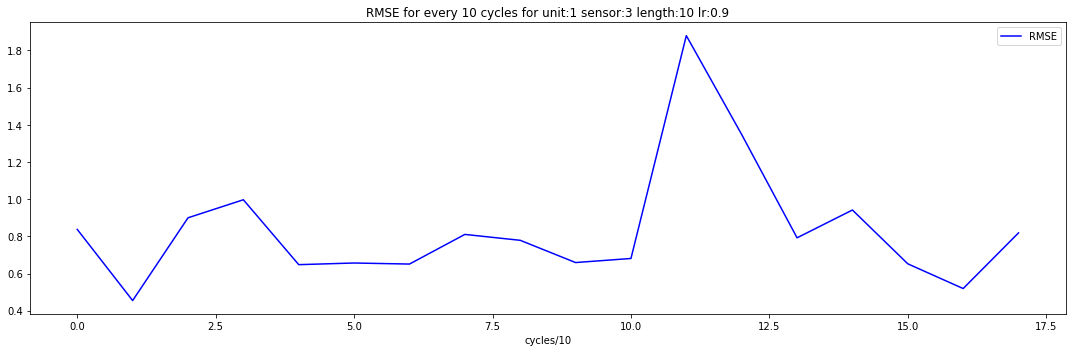

Initialized value of sensor 4 -  mu:[-0.00306015], signma:[0.05533127], thold_ad:[2.99634479], thold_p:3.6999999999999993
no anomaly detected
Initialized value of sensor 5 -  mu:[-0.09967896], signma:[8.79181276], thold_ad:[4.38848053], thold_p:5.499999999999998
no anomaly detected
Initialized value of sensor 6 -  mu:[-0.01509298], signma:[0.06519837], thold_ad:[7.20054965], thold_p:8.799999999999999


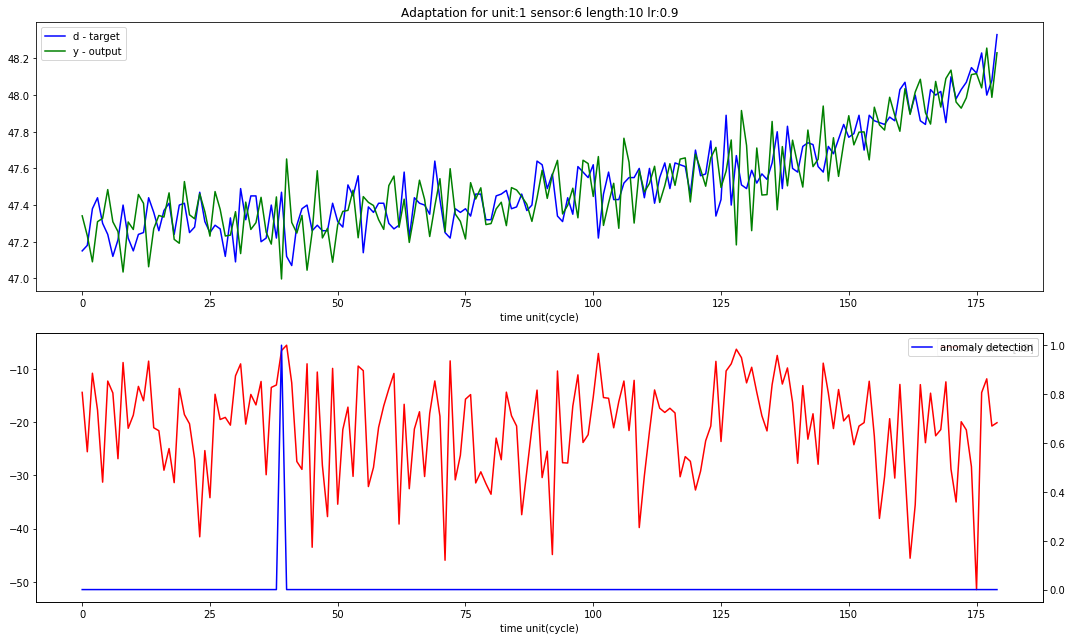

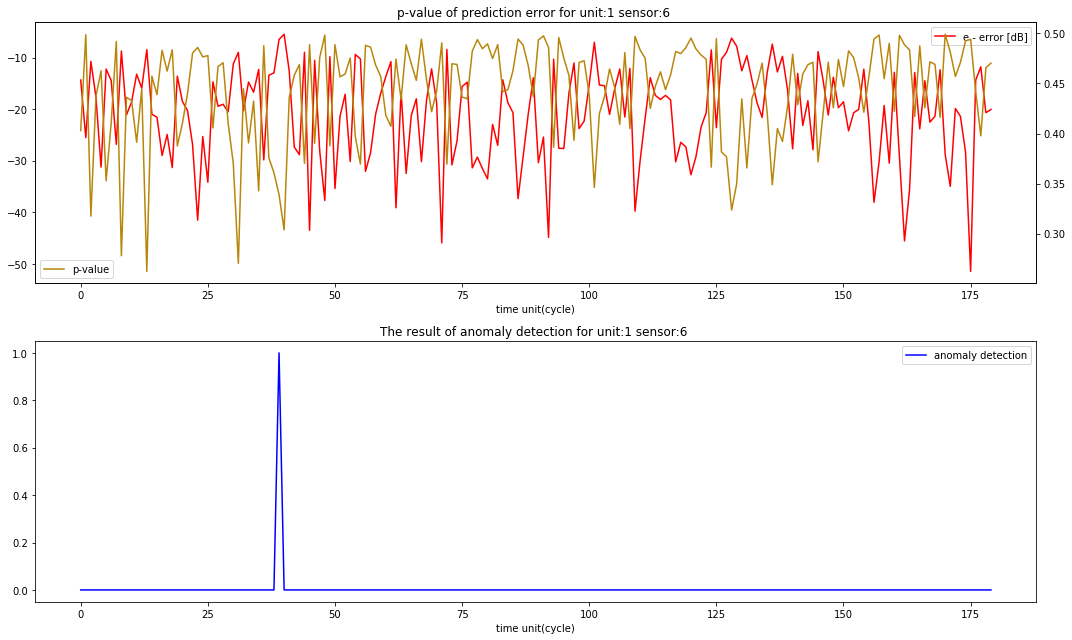

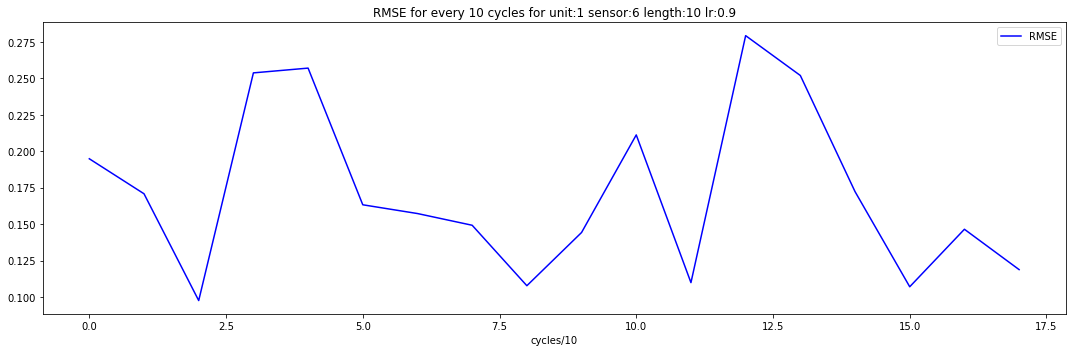

Initialized value of sensor 7 -  mu:[0.03541379], signma:[0.23511044], thold_ad:[10.41776409], thold_p:12.400000000000007
no anomaly detected
Initialized value of sensor 8 -  mu:[-0.01781987], signma:[0.02456494], thold_ad:[7.87752117], thold_p:9.4
no anomaly detected
Initialized value of sensor 9 -  mu:[-1.19968918], signma:[2.04466169], thold_ad:[19.42185543], thold_p:23.20000000000003
no anomaly detected
Initialized value of sensor 10 -  mu:[0.01630554], signma:[0.03679256], thold_ad:[3.01770738], thold_p:3.6999999999999993
no anomaly detected
Initialized value of sensor 11 -  mu:[-0.19065917], signma:[0.38240495], thold_ad:[13.88968508], thold_p:16.600000000000016
no anomaly detected
Initialized value of sensor 12 -  mu:[-0.03725729], signma:[0.1525524], thold_ad:[5.03574535], thold_p:6.099999999999998


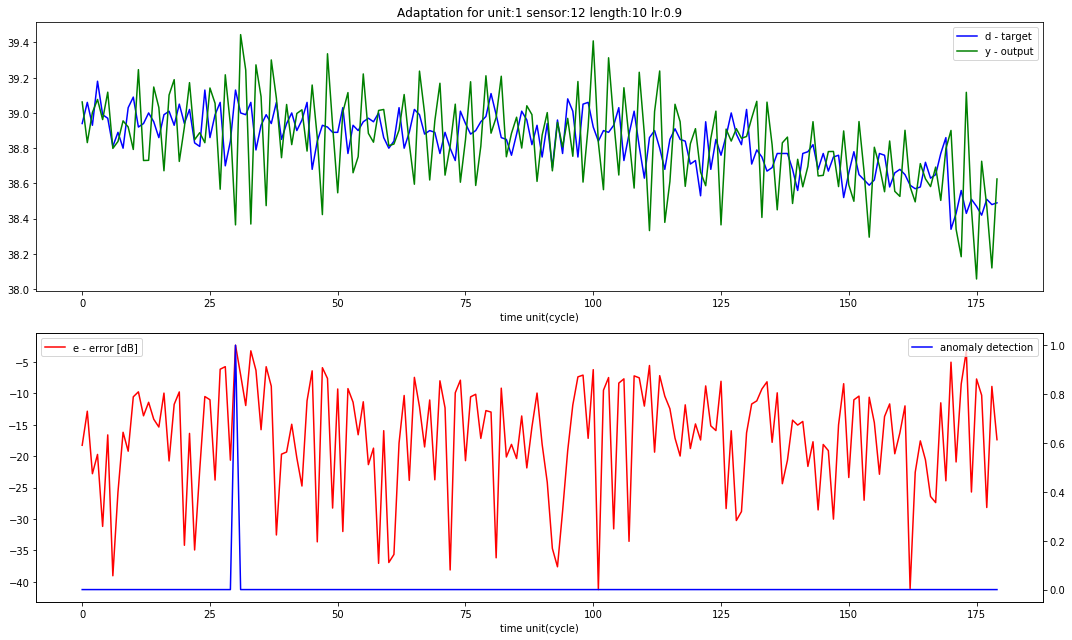

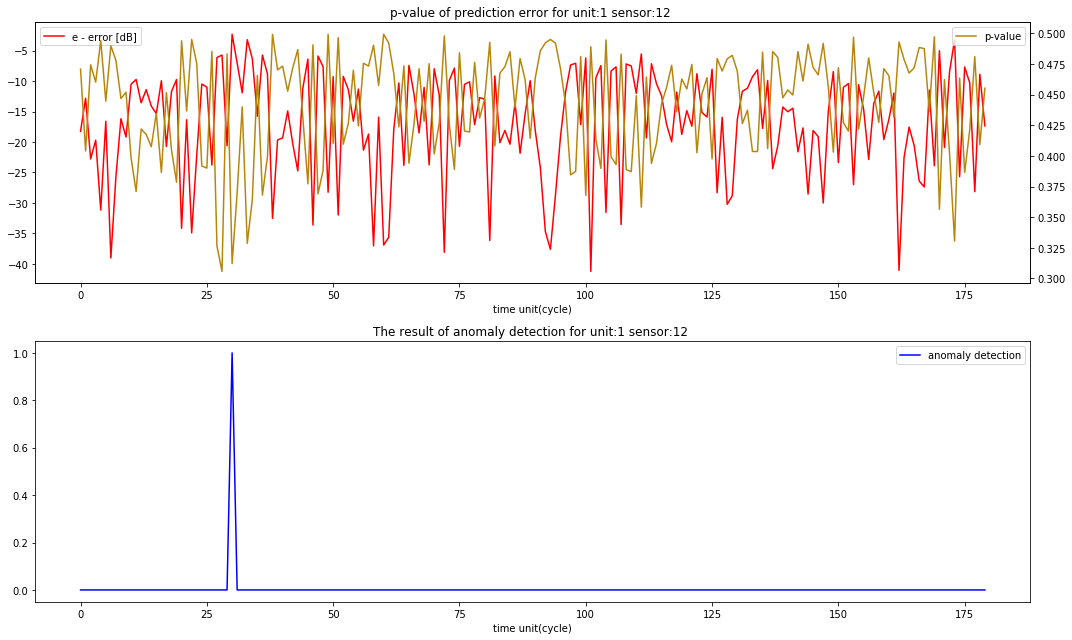

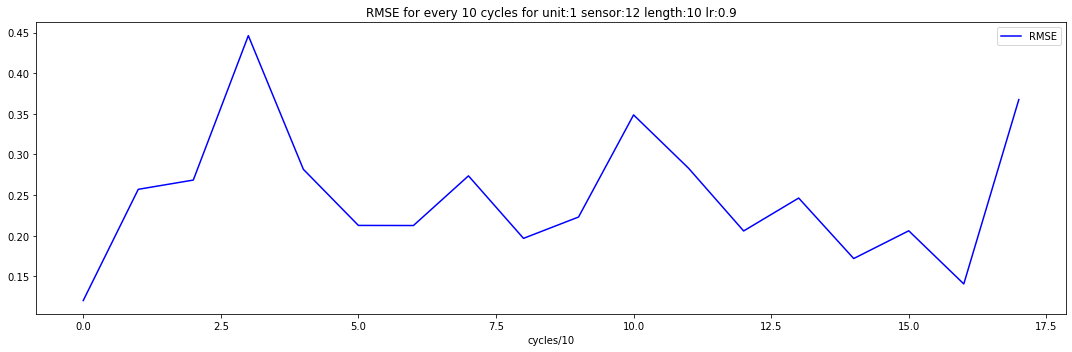

Initialized value of sensor 13 -  mu:[-0.05108309], signma:[0.20472864], thold_ad:[2.07230436], thold_p:2.5


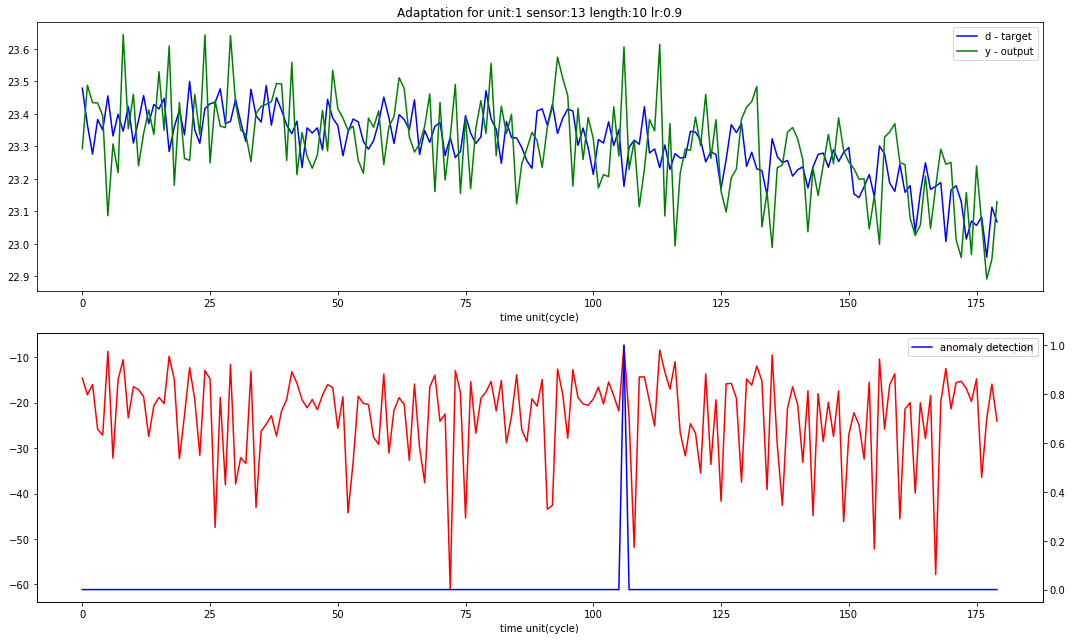

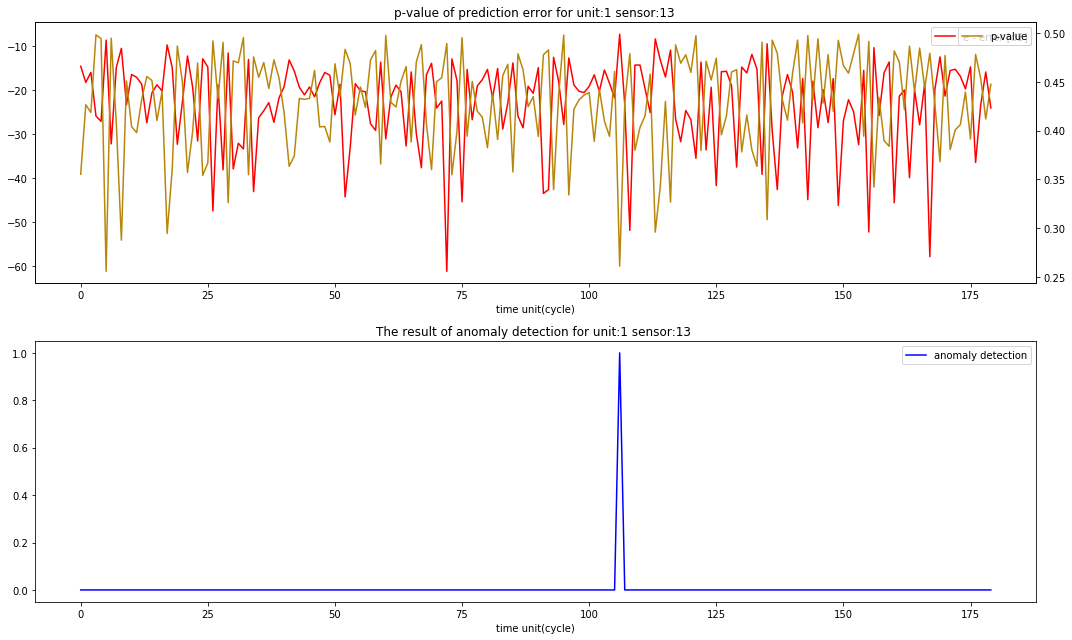

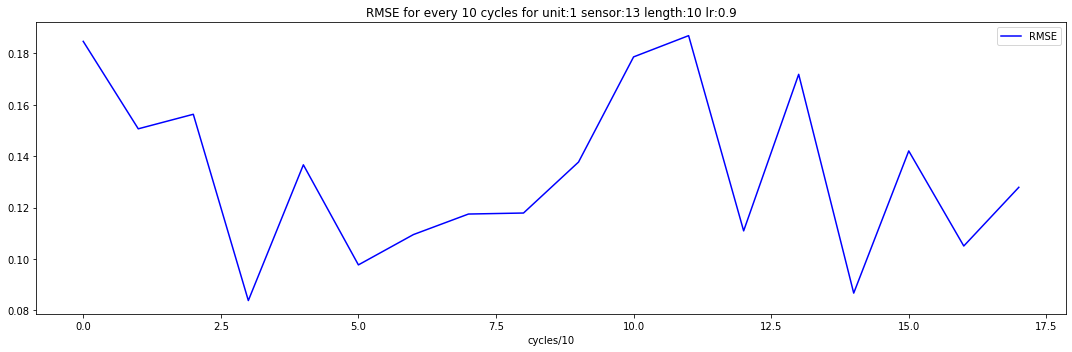

Initialized value of sensor 0 -  mu:[-0.0009445], signma:[0.44993427], thold_ad:[3.60113423], thold_p:4.299999999999999
no anomaly detected
Initialized value of sensor 1 -  mu:[2.38304486], signma:[1.04535635], thold_ad:[36.46325158], thold_p:43.599999999999945


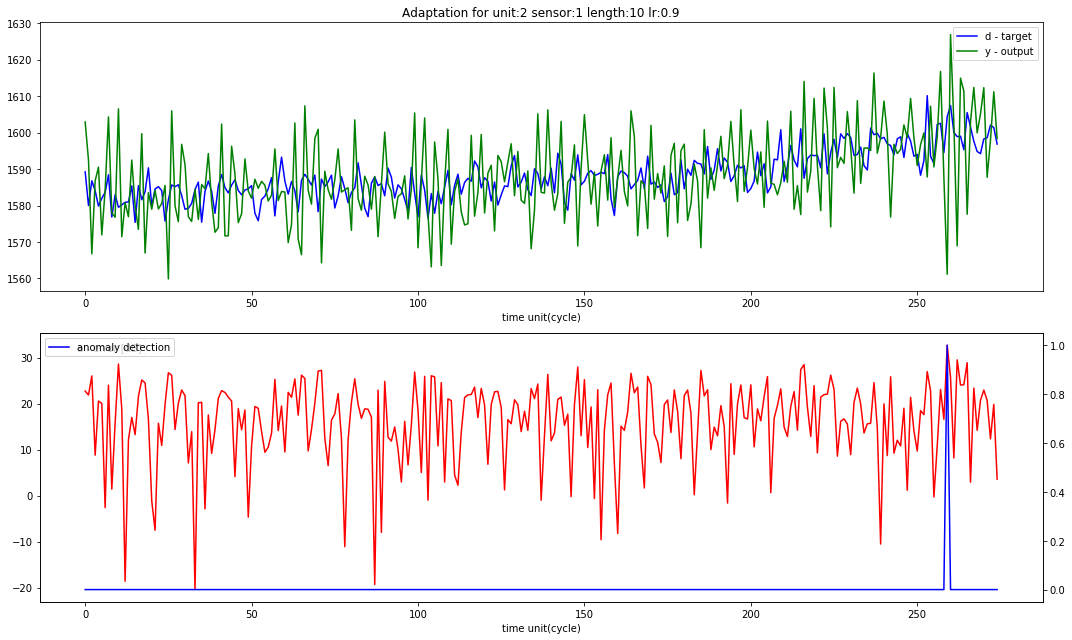

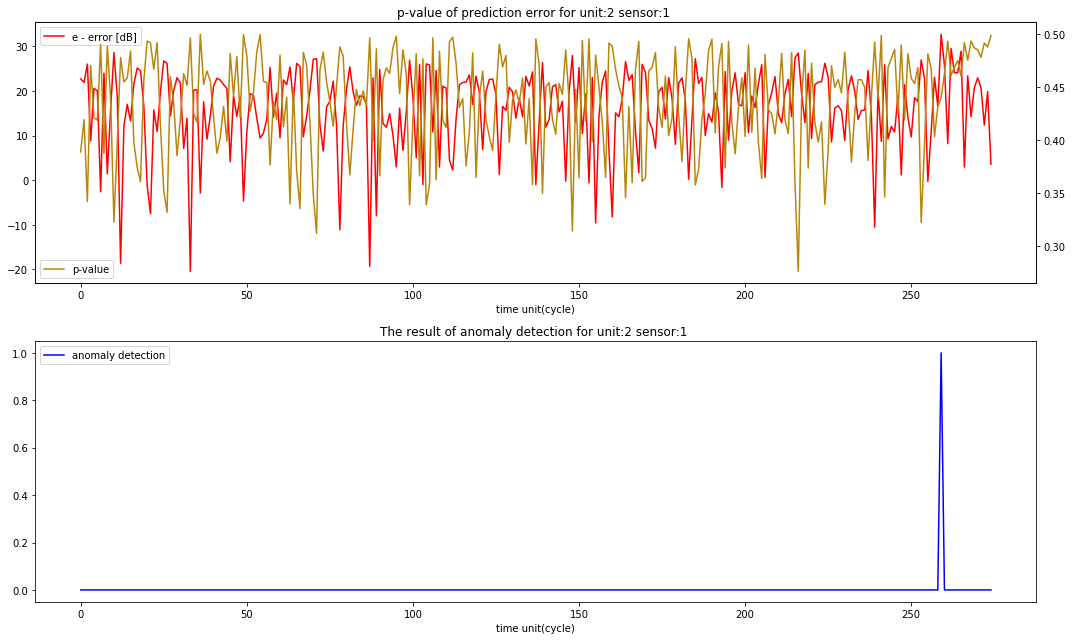

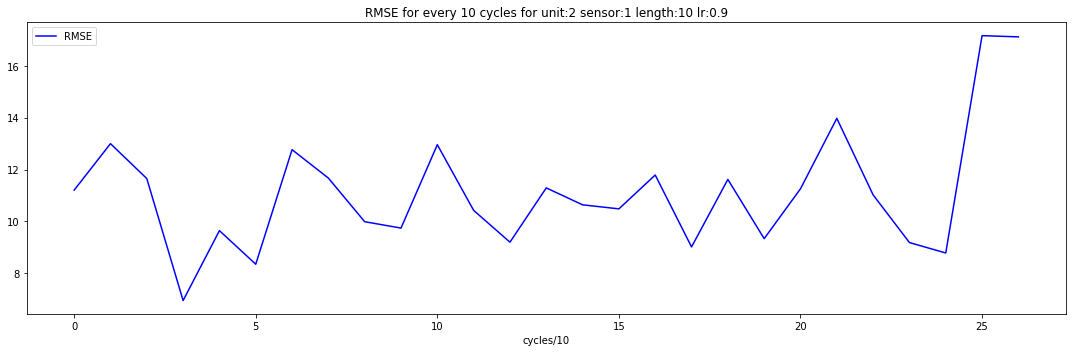

Initialized value of sensor 2 -  mu:[-0.87352051], signma:[6.14989183], thold_ad:[4.18121736], thold_p:5.199999999999998
no anomaly detected
Initialized value of sensor 3 -  mu:[-0.03810892], signma:[0.2427025], thold_ad:[12.82335616], thold_p:15.400000000000015
no anomaly detected
Initialized value of sensor 4 -  mu:[0.00999582], signma:[0.02562703], thold_ad:[7.85897584], thold_p:9.4


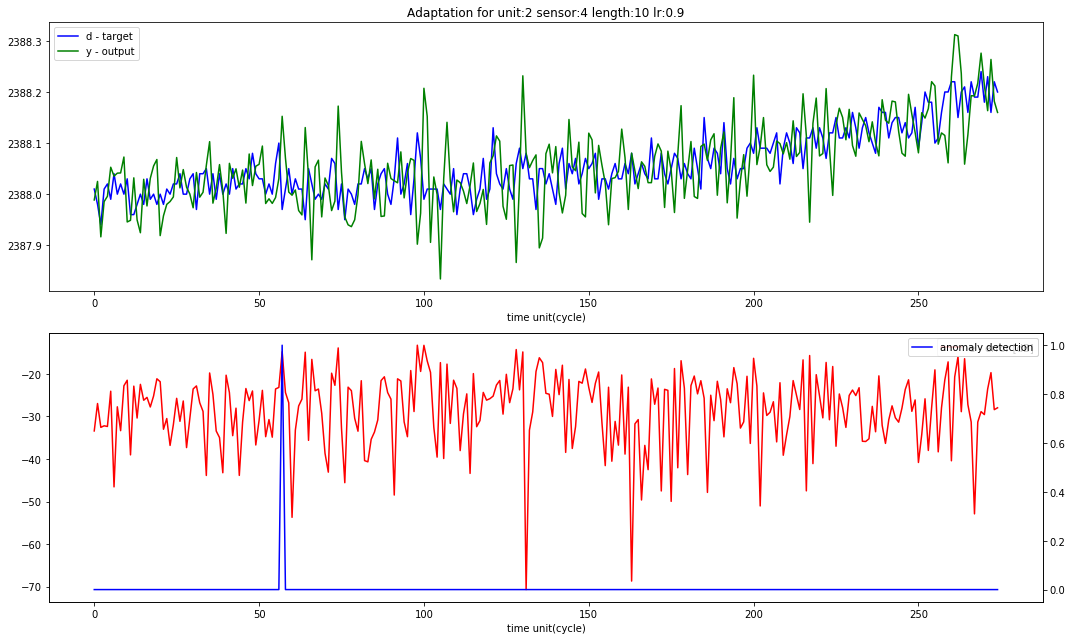

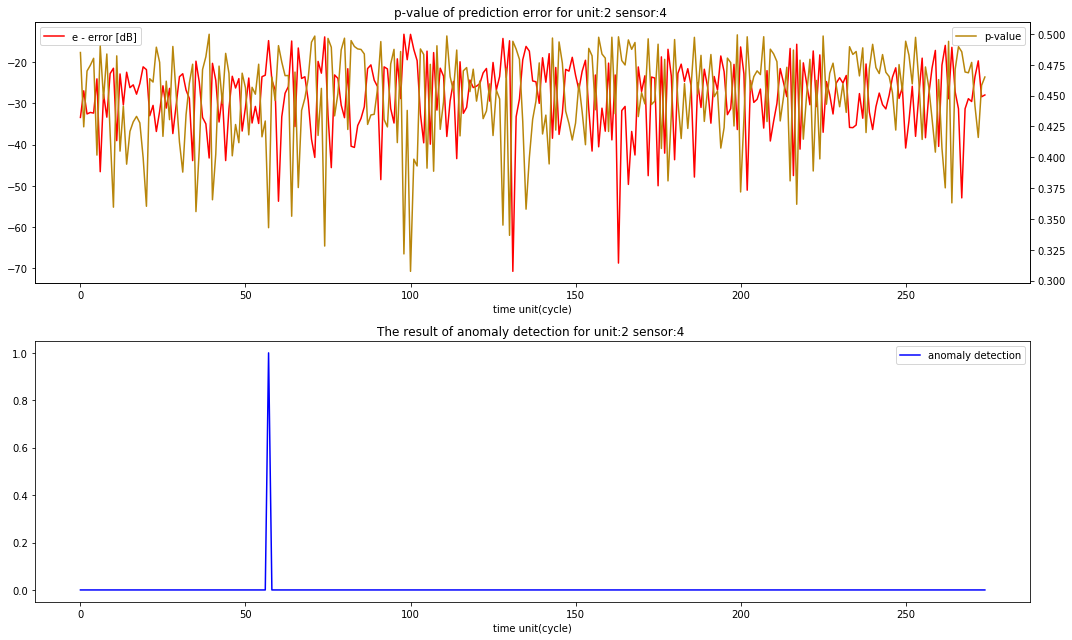

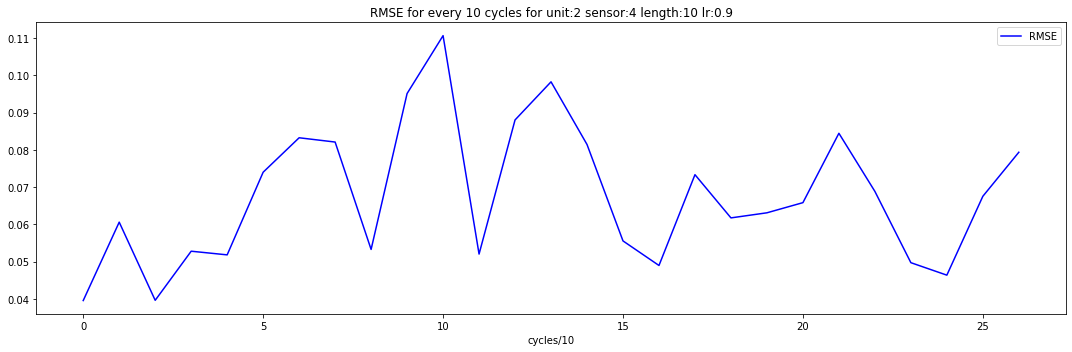

Initialized value of sensor 5 -  mu:[1.28674724], signma:[2.85560829], thold_ad:[12.53295582], thold_p:15.100000000000014


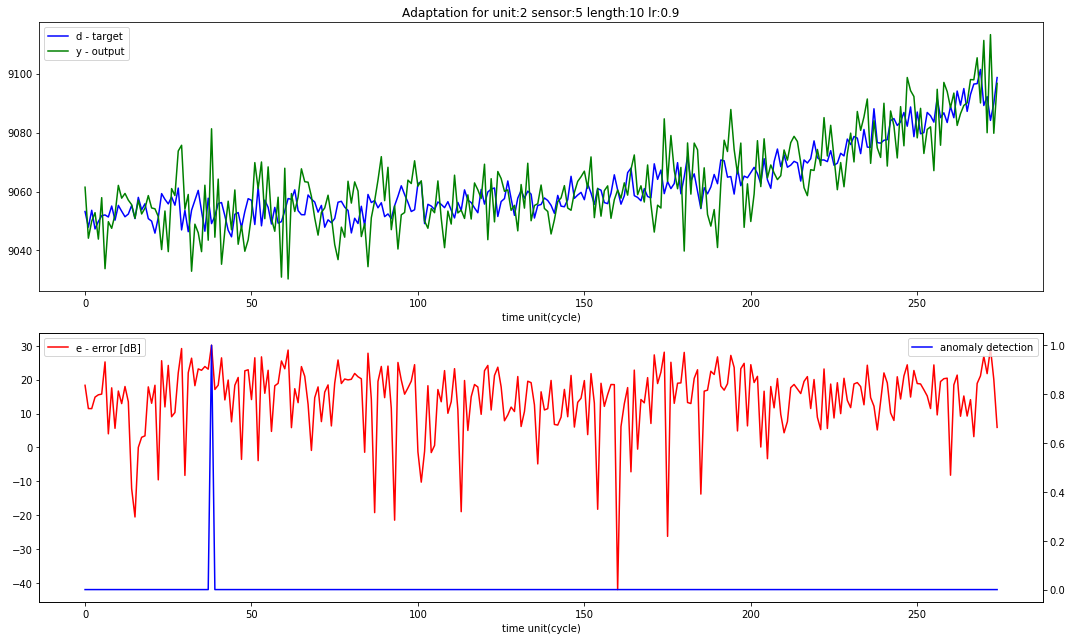

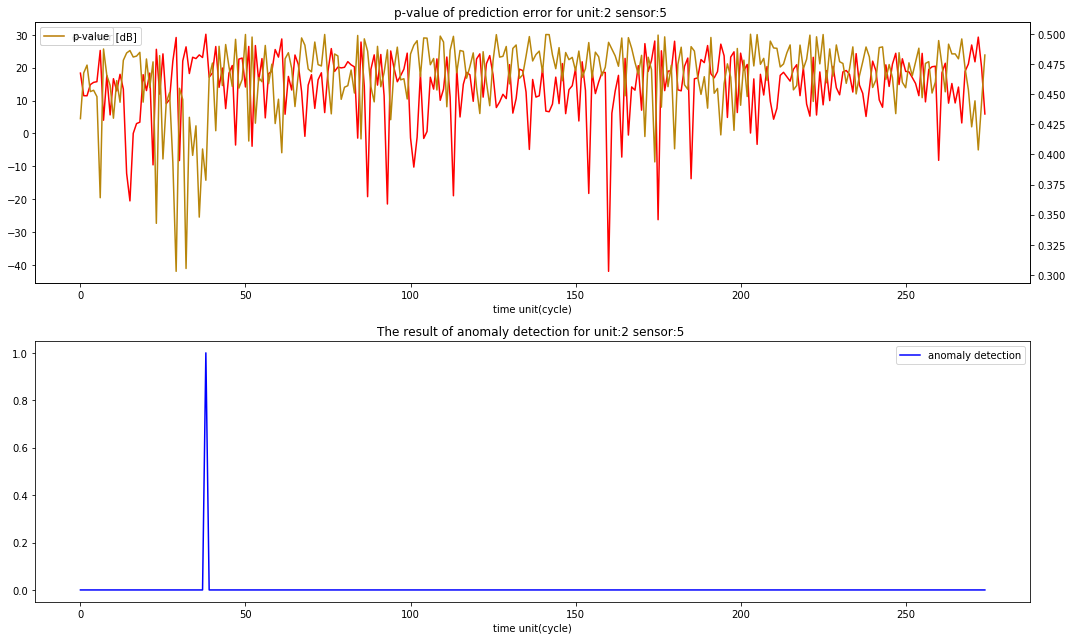

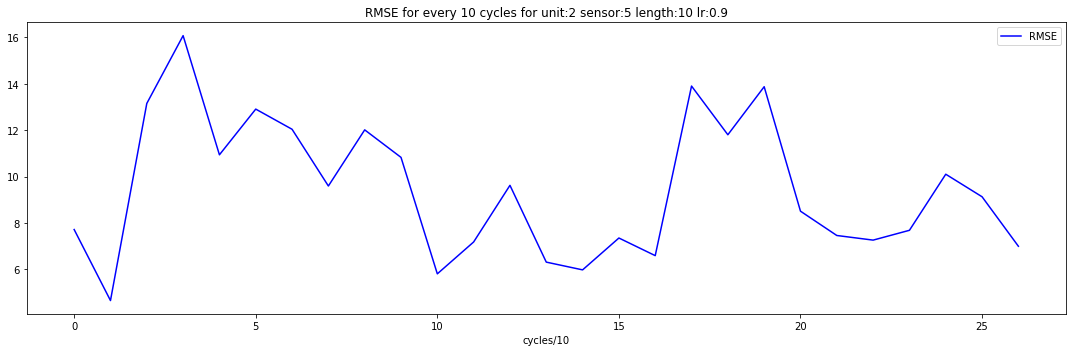

Initialized value of sensor 6 -  mu:[-0.04868401], signma:[0.03603384], thold_ad:[16.92851015], thold_p:20.200000000000024


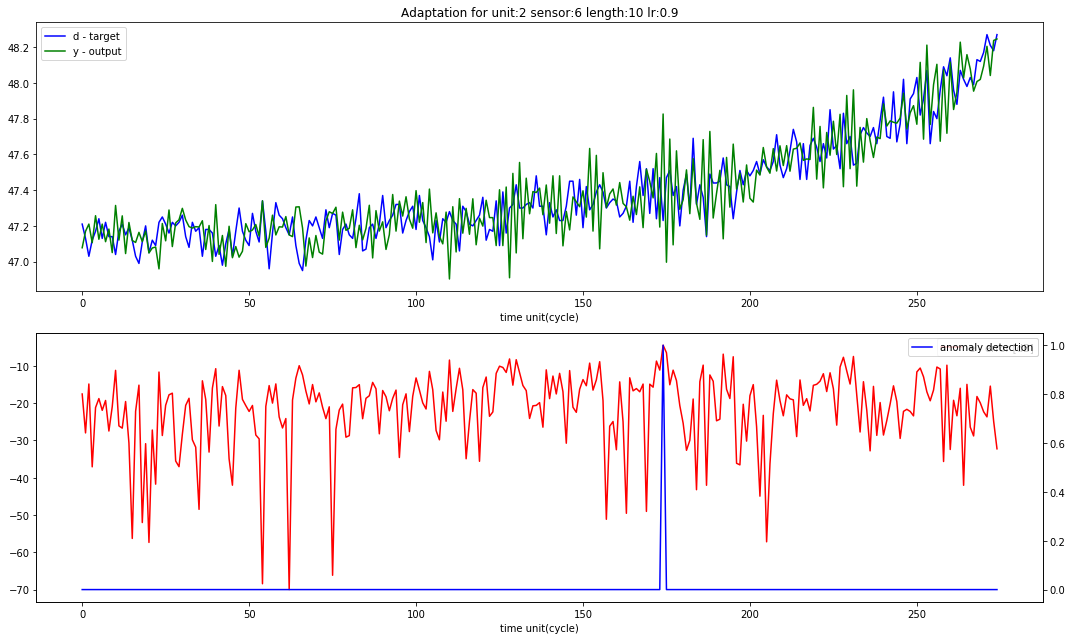

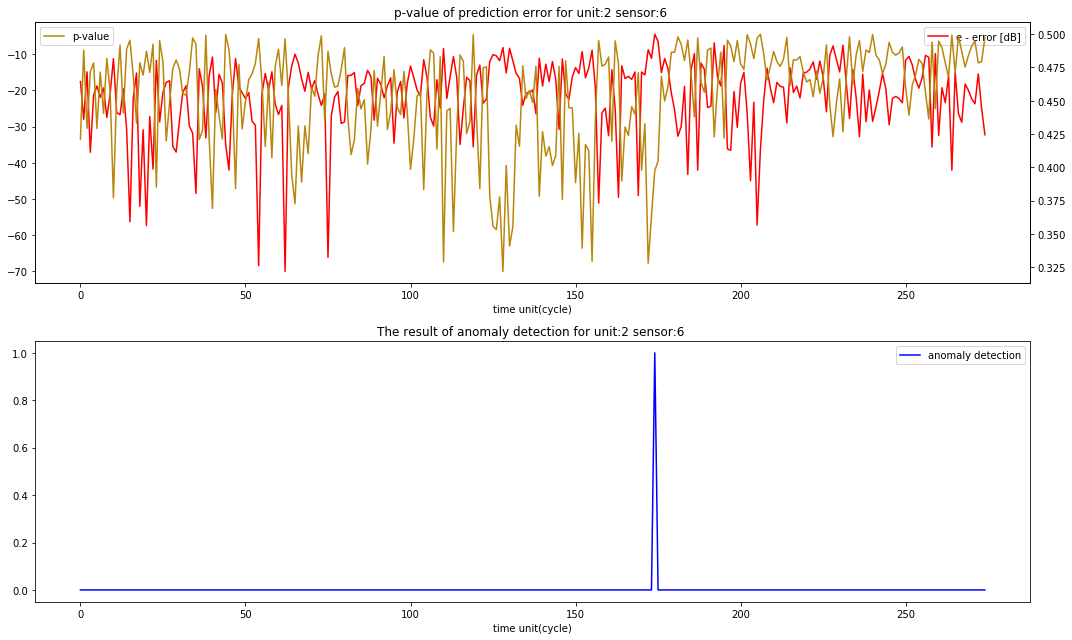

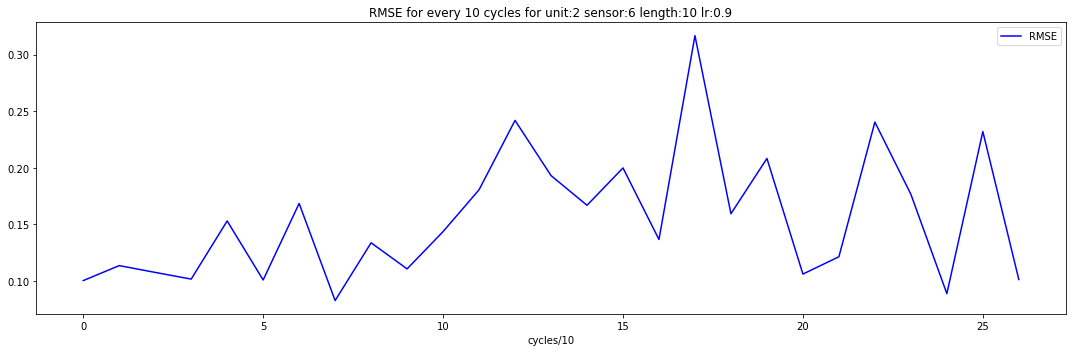

Initialized value of sensor 7 -  mu:[0.36471137], signma:[0.9825688], thold_ad:[2.30031676], thold_p:2.8


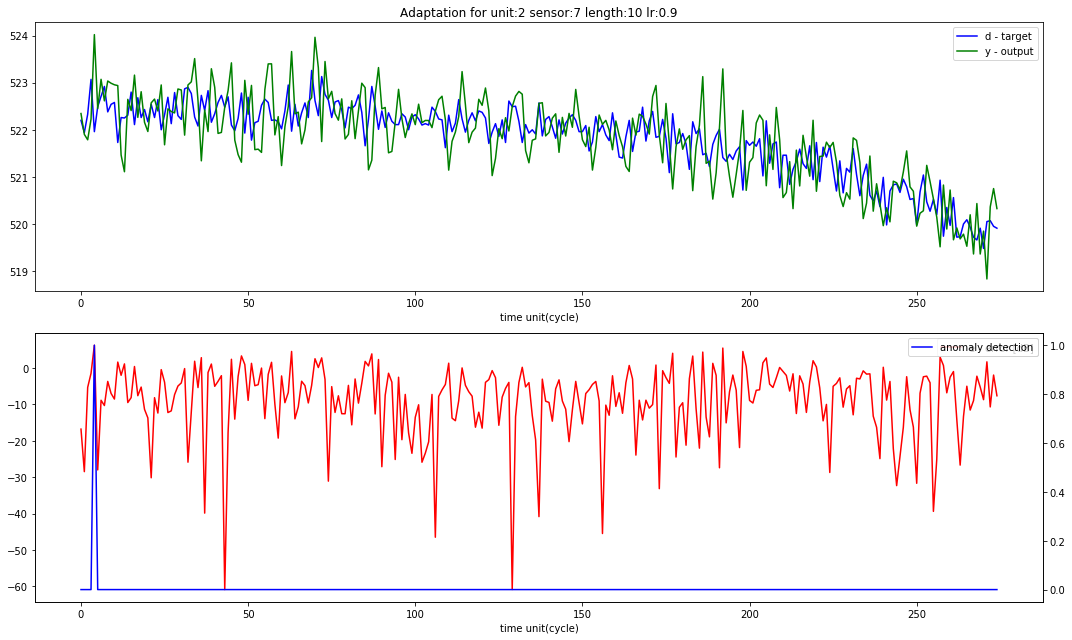

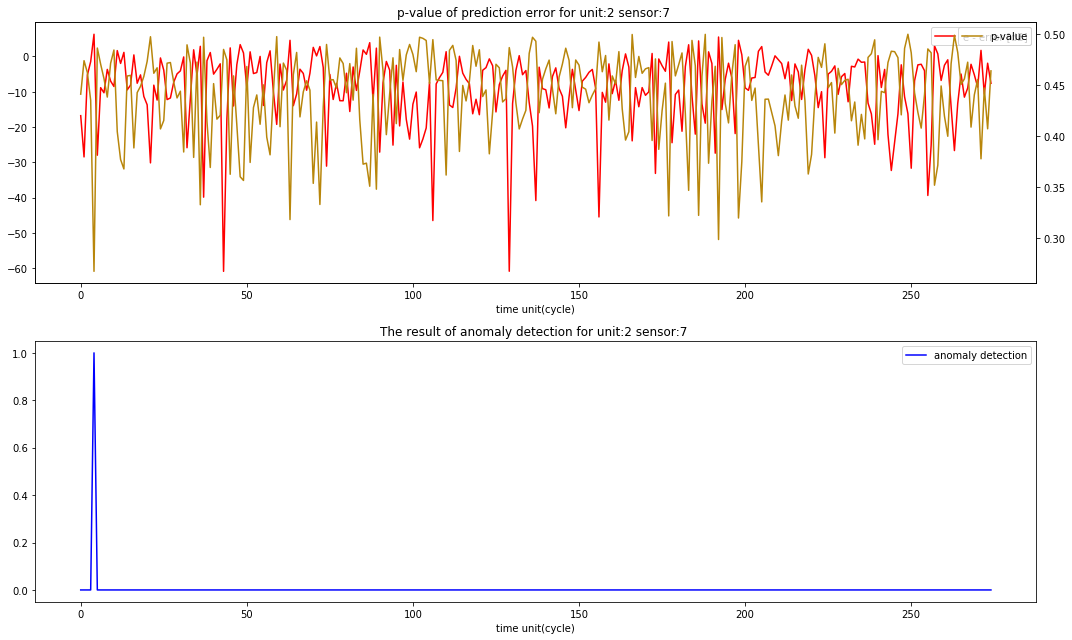

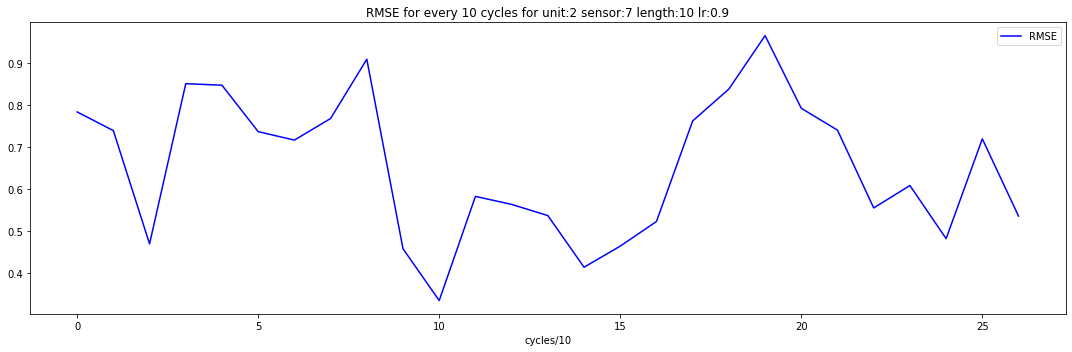

Initialized value of sensor 8 -  mu:[-0.00589116], signma:[0.03811208], thold_ad:[4.14742699], thold_p:5.199999999999998


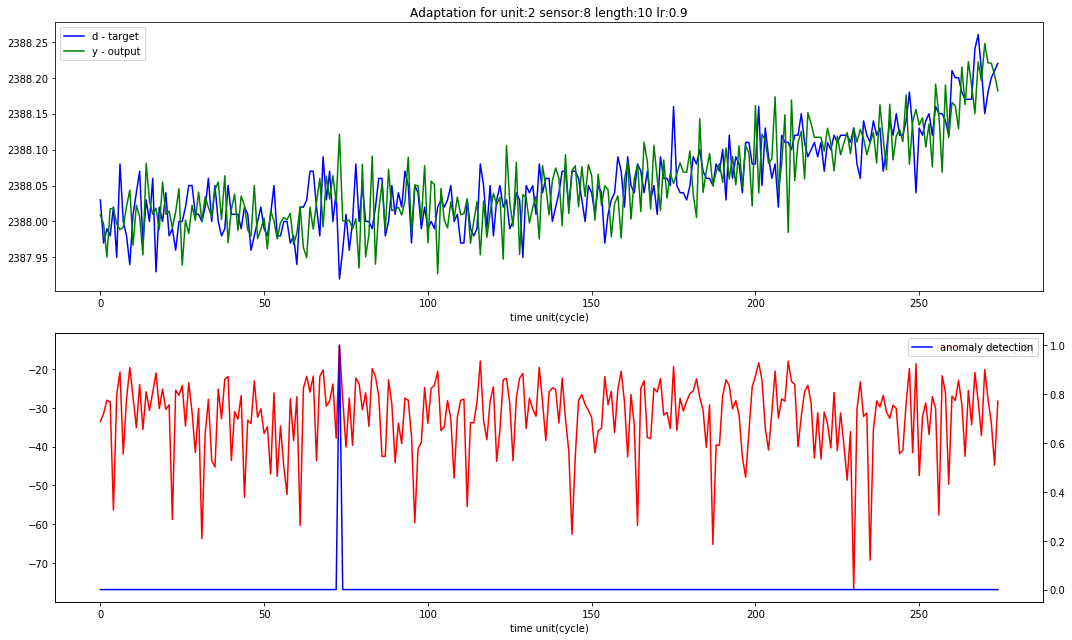

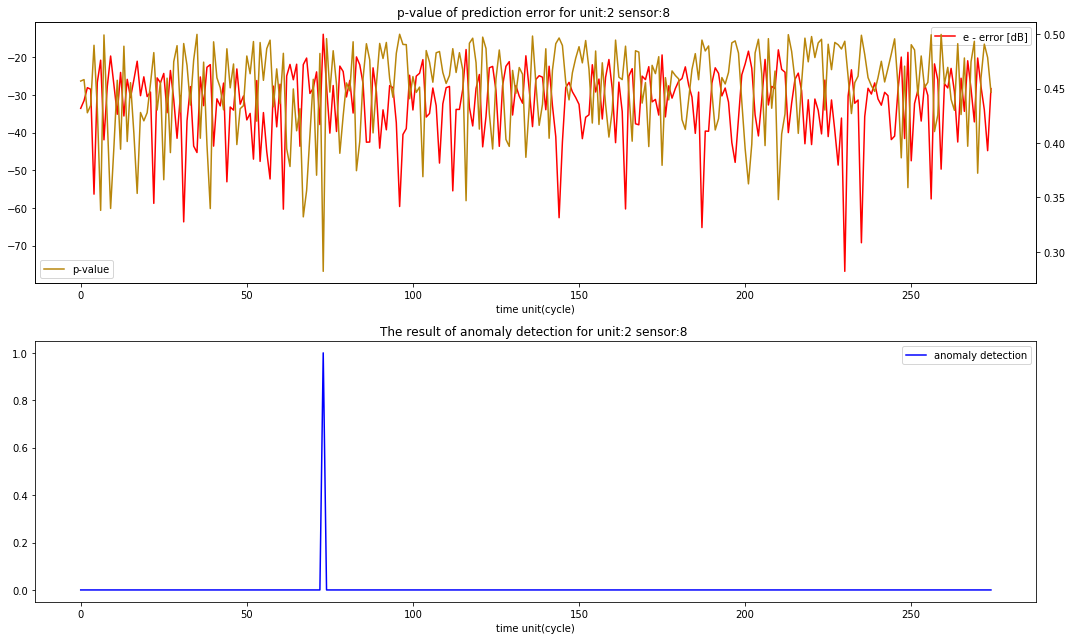

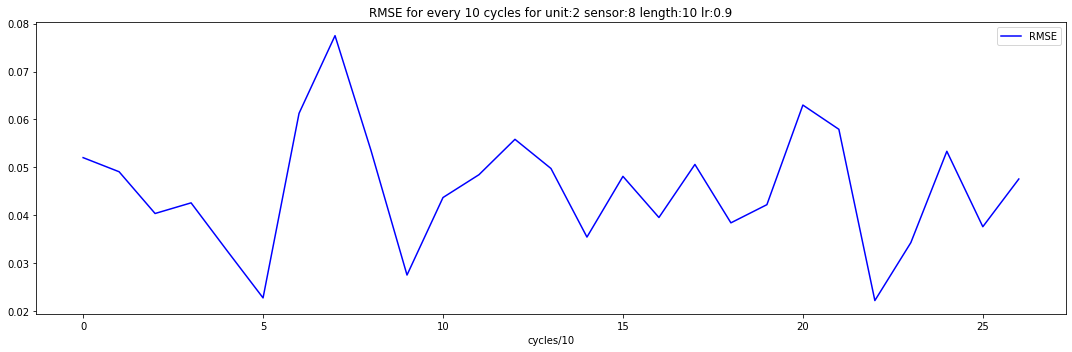

Initialized value of sensor 9 -  mu:[0.52424222], signma:[9.64739068], thold_ad:[3.22979942], thold_p:3.999999999999999
no anomaly detected
Initialized value of sensor 10 -  mu:[0.00768255], signma:[0.00980909], thold_ad:[10.87196698], thold_p:13.000000000000009


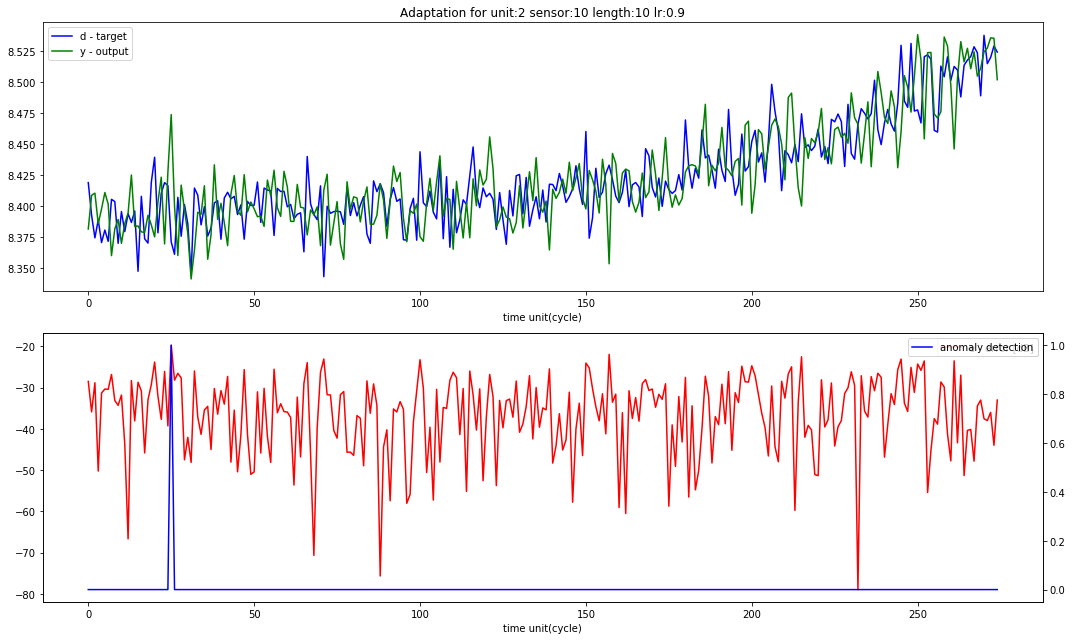

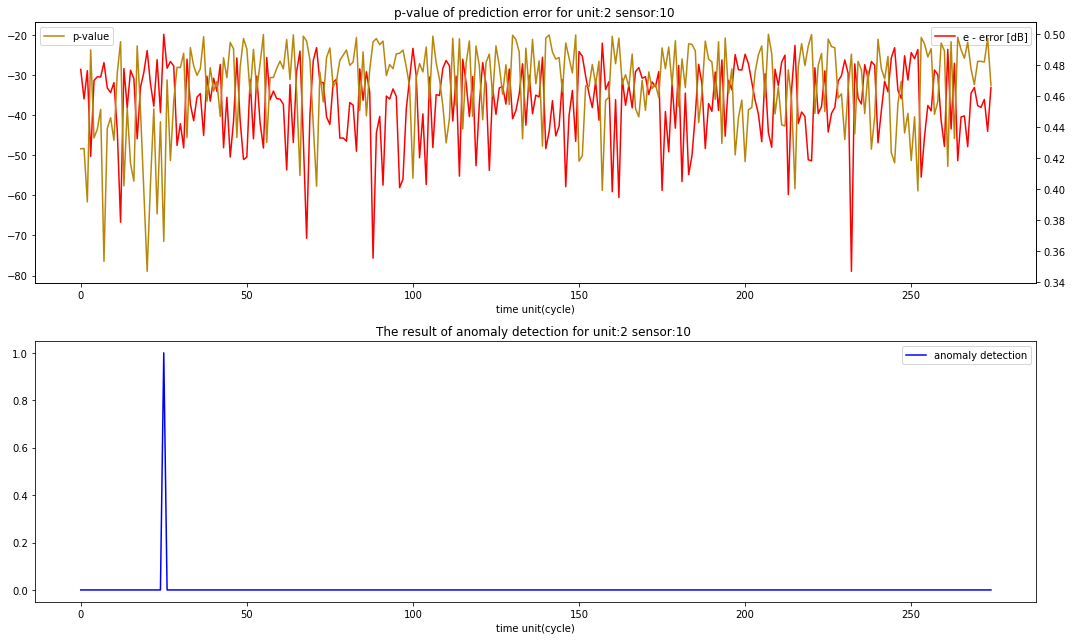

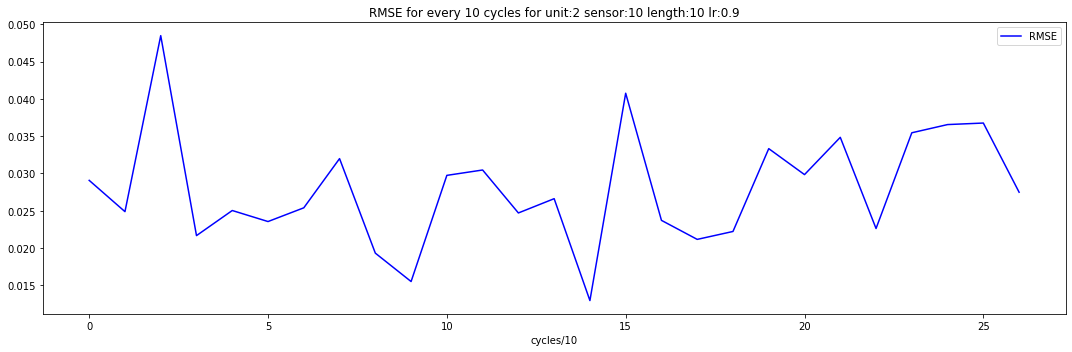

Initialized value of sensor 11 -  mu:[0.28298954], signma:[2.82021946], thold_ad:[2.10398763], thold_p:2.5


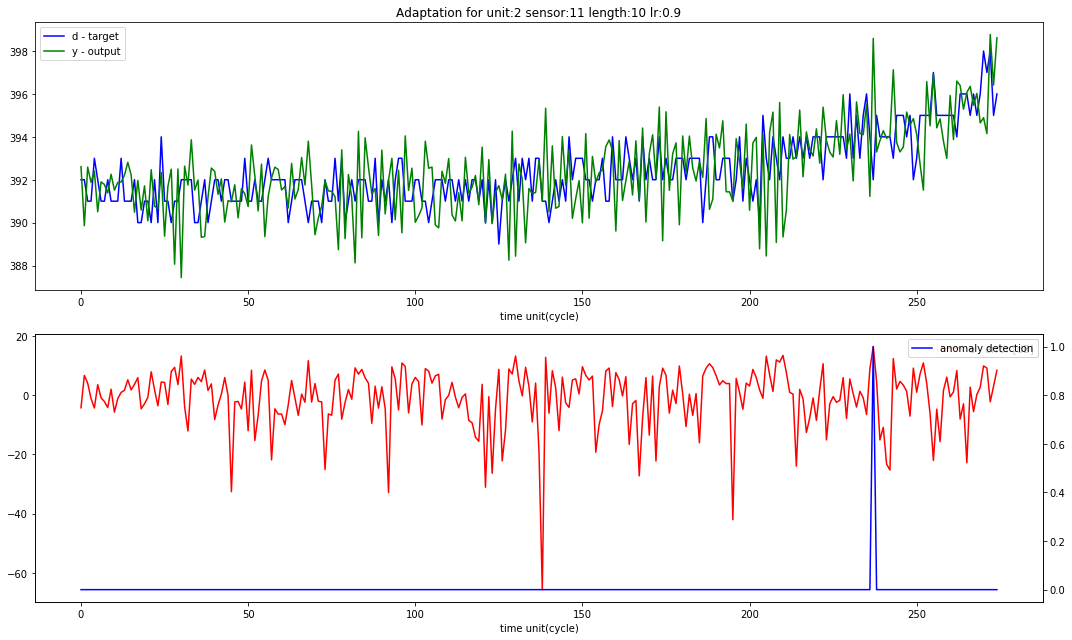

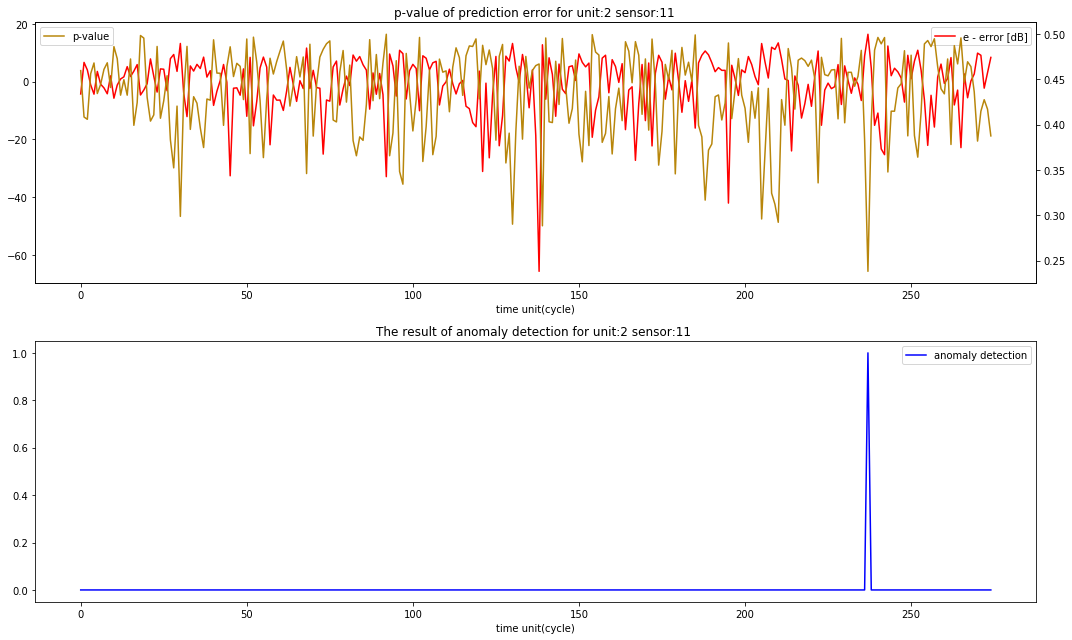

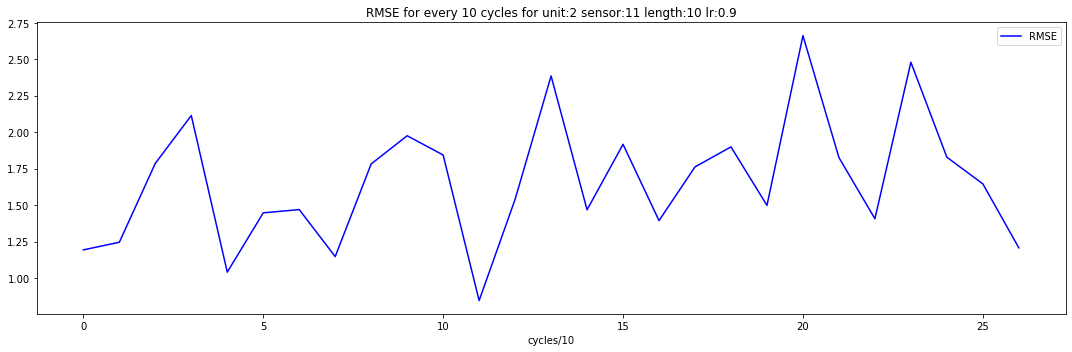

Initialized value of sensor 12 -  mu:[-0.09383734], signma:[0.23181045], thold_ad:[3.01951644], thold_p:3.6999999999999993


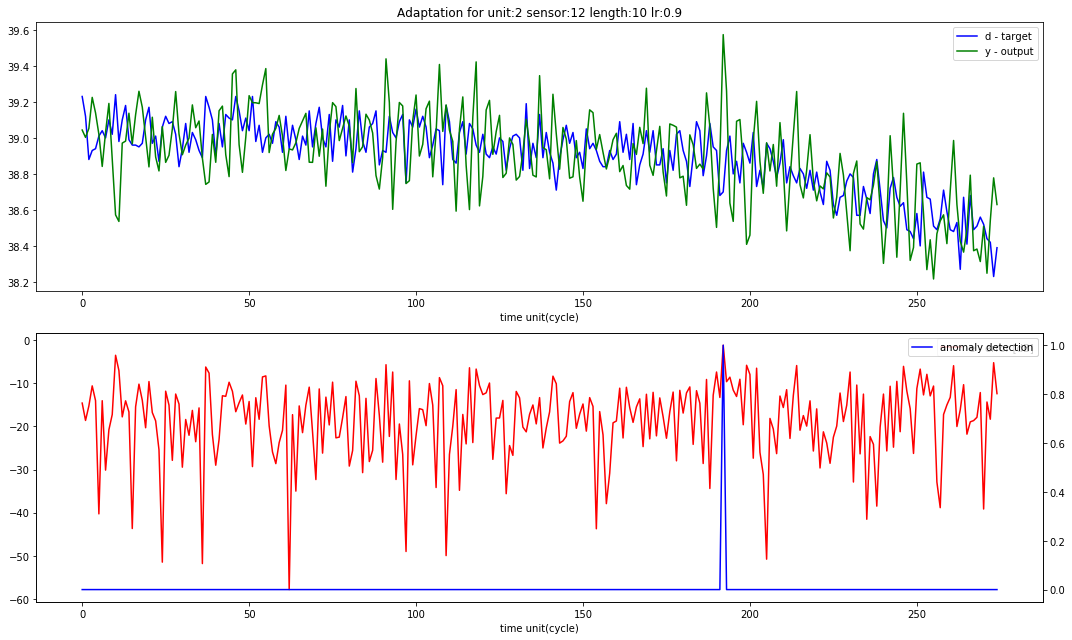

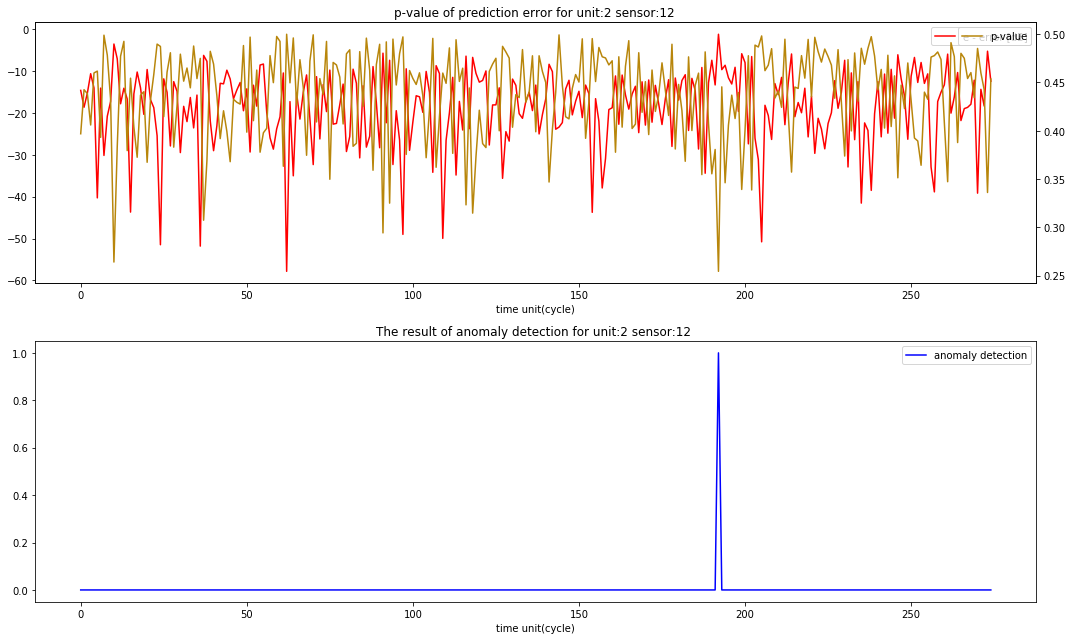

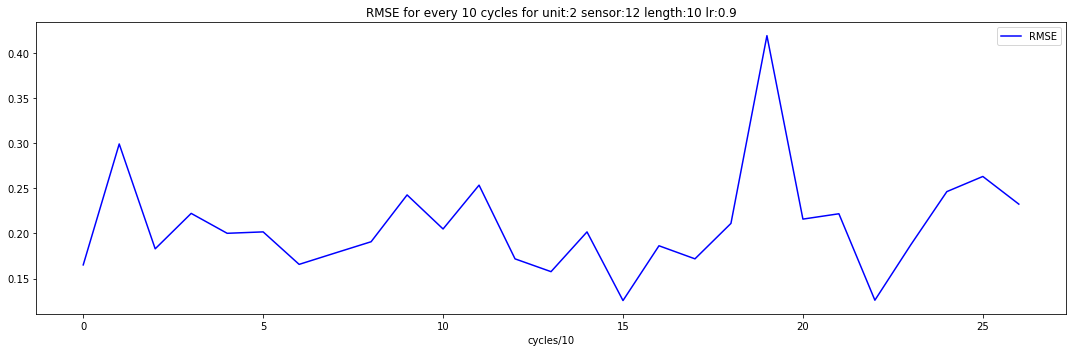

Initialized value of sensor 13 -  mu:[-0.01855223], signma:[0.03040101], thold_ad:[10.71189711], thold_p:13.000000000000009
no anomaly detected
Initialized value of sensor 0 -  mu:[-0.01506171], signma:[0.35113133], thold_ad:[5.30681125], thold_p:6.399999999999998


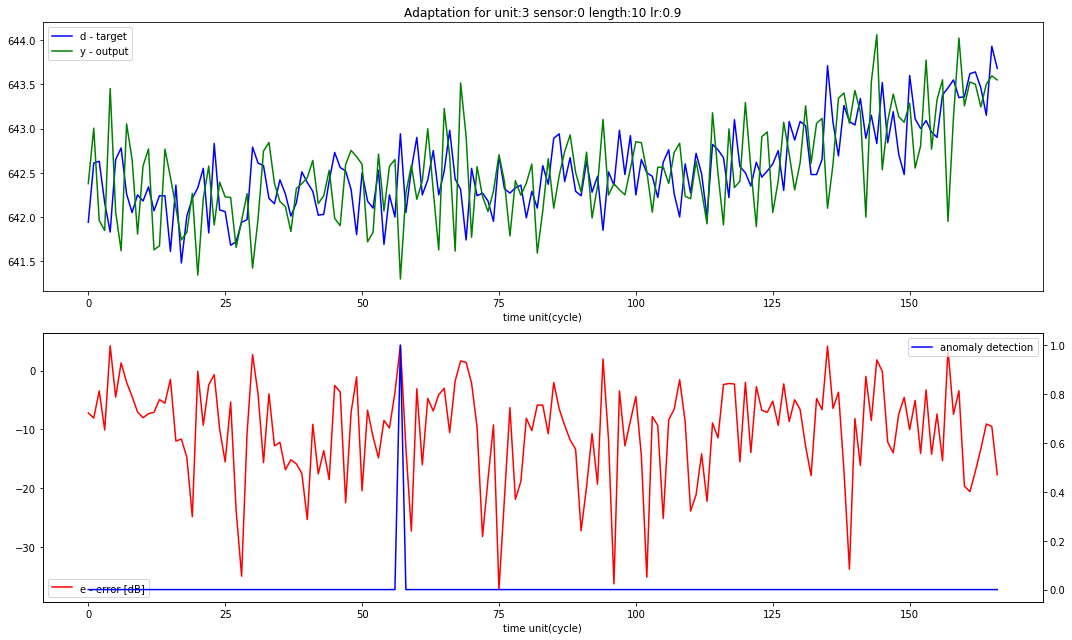

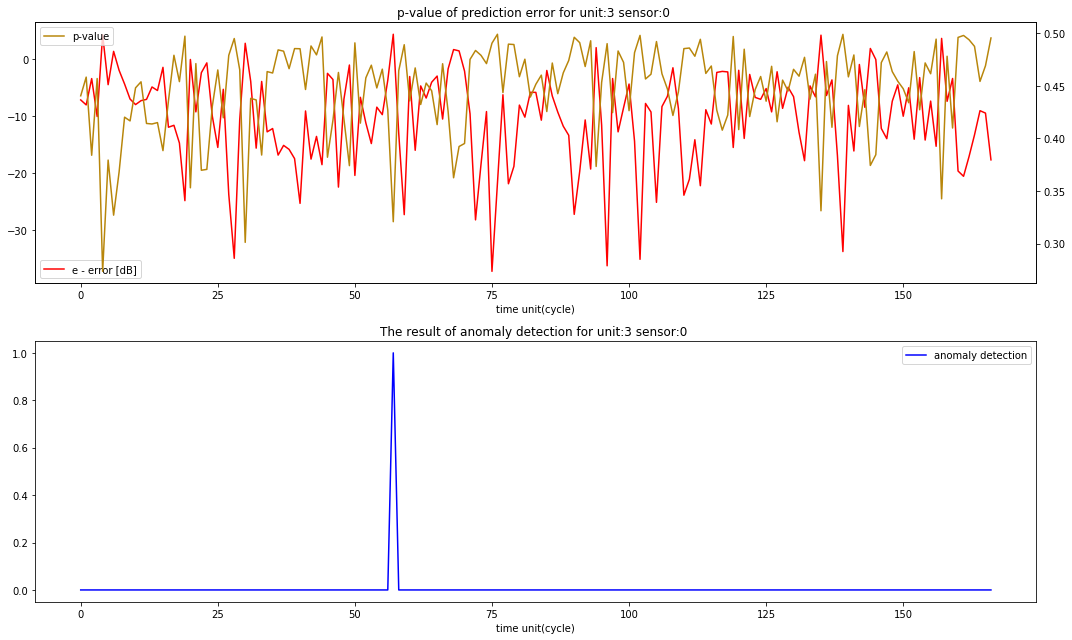

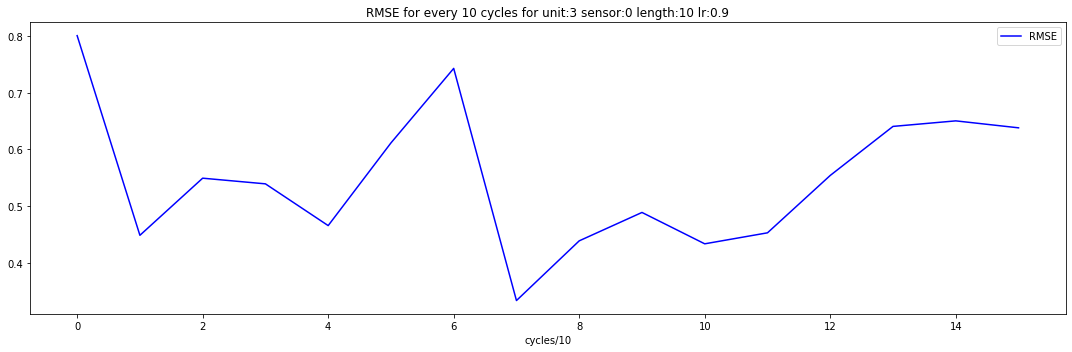

Initialized value of sensor 1 -  mu:[1.51791319], signma:[5.5777275], thold_ad:[4.4074427], thold_p:5.499999999999998
no anomaly detected
Initialized value of sensor 2 -  mu:[0.78648862], signma:[5.06886039], thold_ad:[5.27016825], thold_p:6.399999999999998
no anomaly detected
Initialized value of sensor 3 -  mu:[0.16626531], signma:[0.0473083], thold_ad:[67.62976357], thold_p:80.4999999999996
no anomaly detected
Initialized value of sensor 4 -  mu:[0.00757869], signma:[0.10307529], thold_ad:[1.92037378], thold_p:2.5


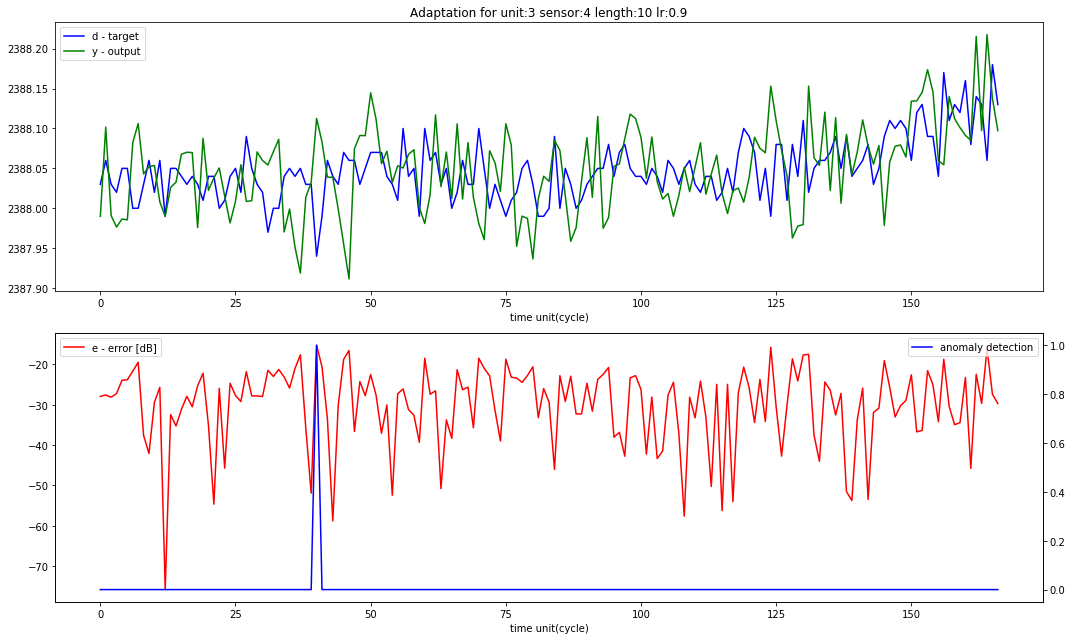

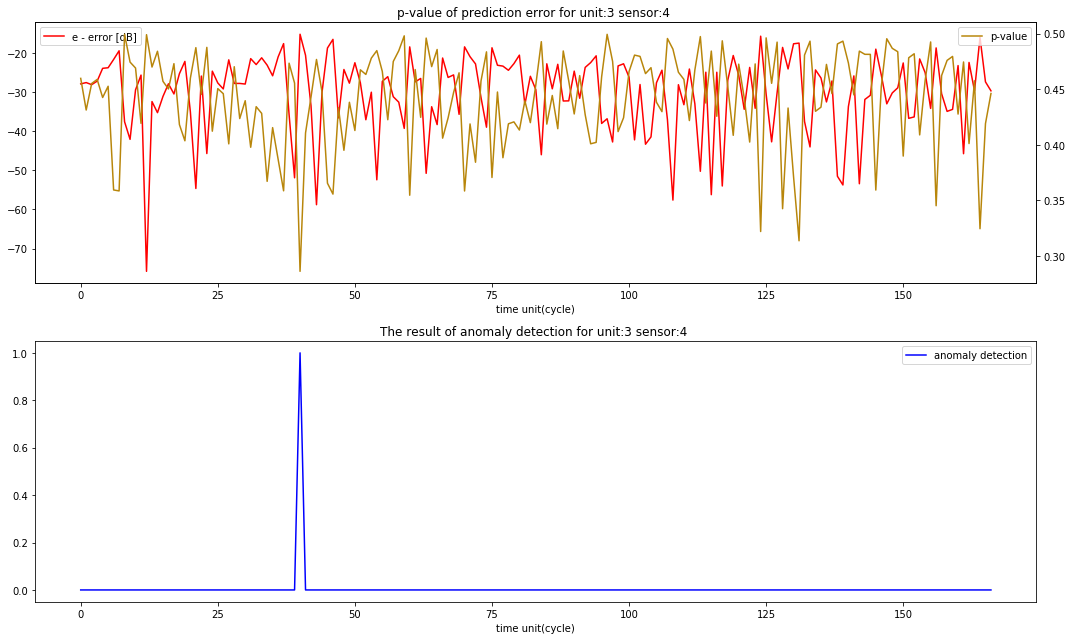

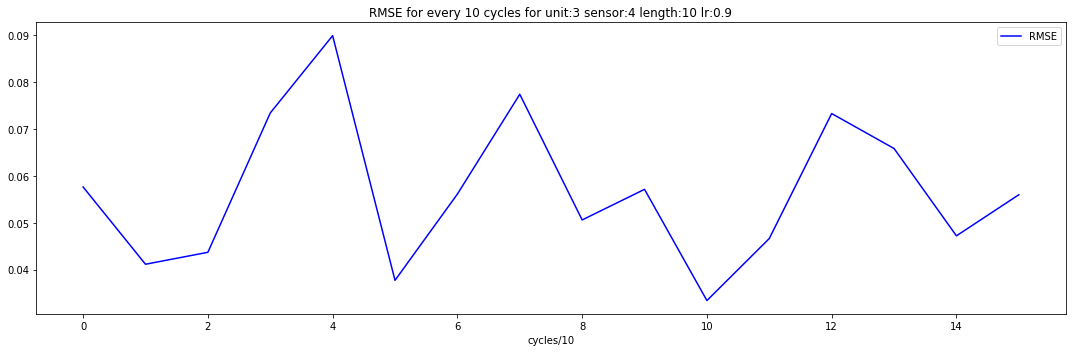

Initialized value of sensor 5 -  mu:[-0.33102946], signma:[1.77042632], thold_ad:[18.63975281], thold_p:22.30000000000003
no anomaly detected
Initialized value of sensor 6 -  mu:[-0.0632236], signma:[0.1456934], thold_ad:[4.76955367], thold_p:5.799999999999998
no anomaly detected
Initialized value of sensor 7 -  mu:[-0.11676231], signma:[0.13983504], thold_ad:[15.65504273], thold_p:18.70000000000002


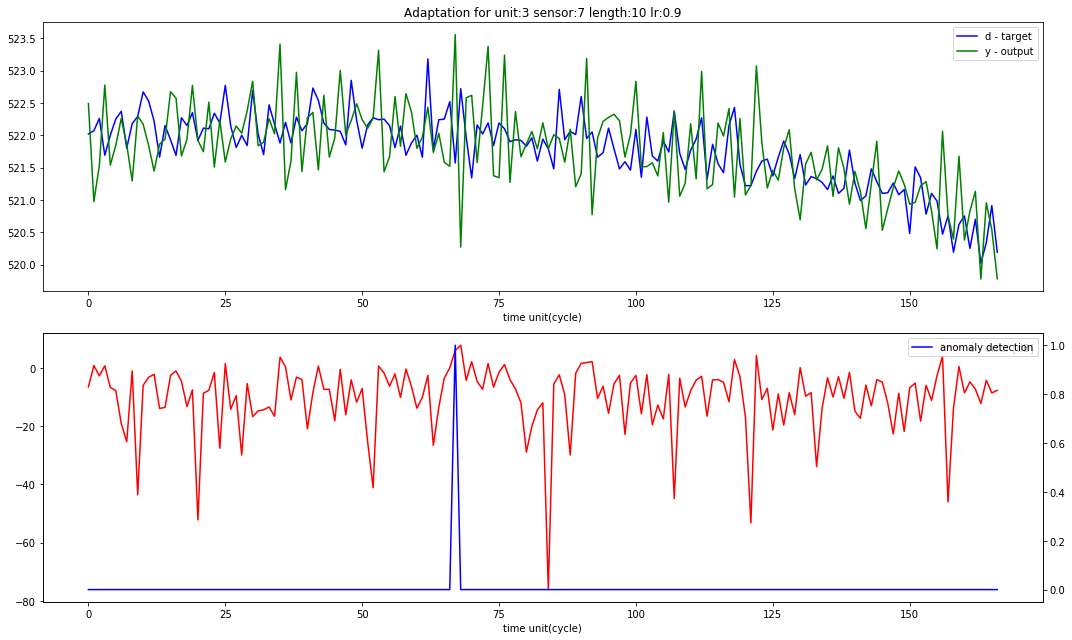

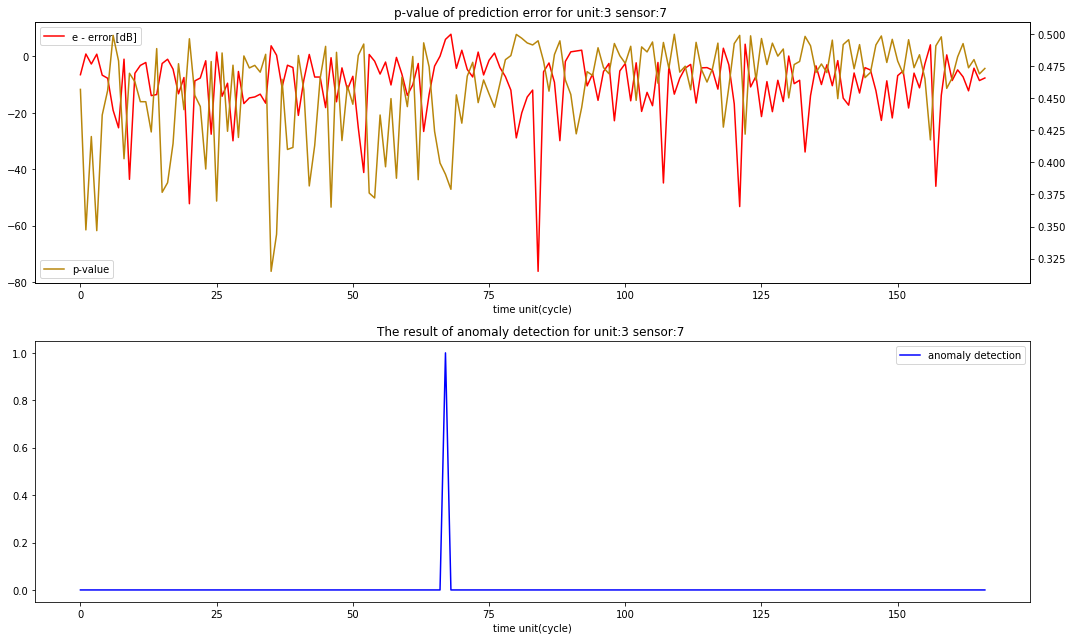

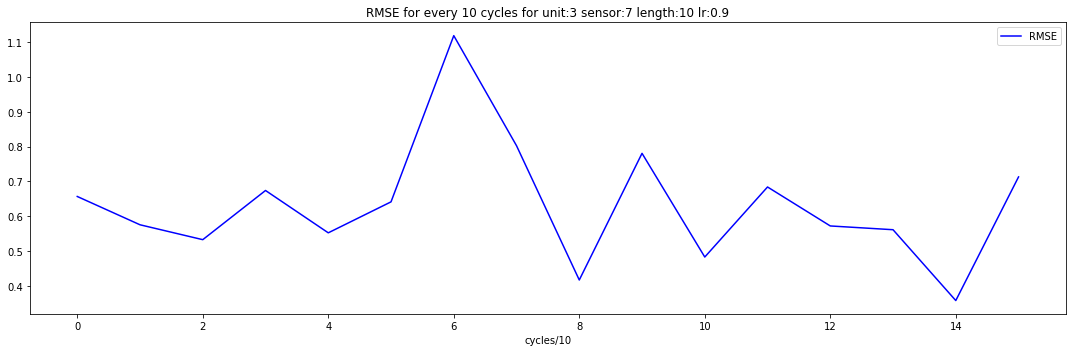

Initialized value of sensor 8 -  mu:[-0.02165524], signma:[0.03986993], thold_ad:[6.77160792], thold_p:8.199999999999998
no anomaly detected
Initialized value of sensor 9 -  mu:[-1.57496761], signma:[2.70985603], thold_ad:[8.23620086], thold_p:10.000000000000002


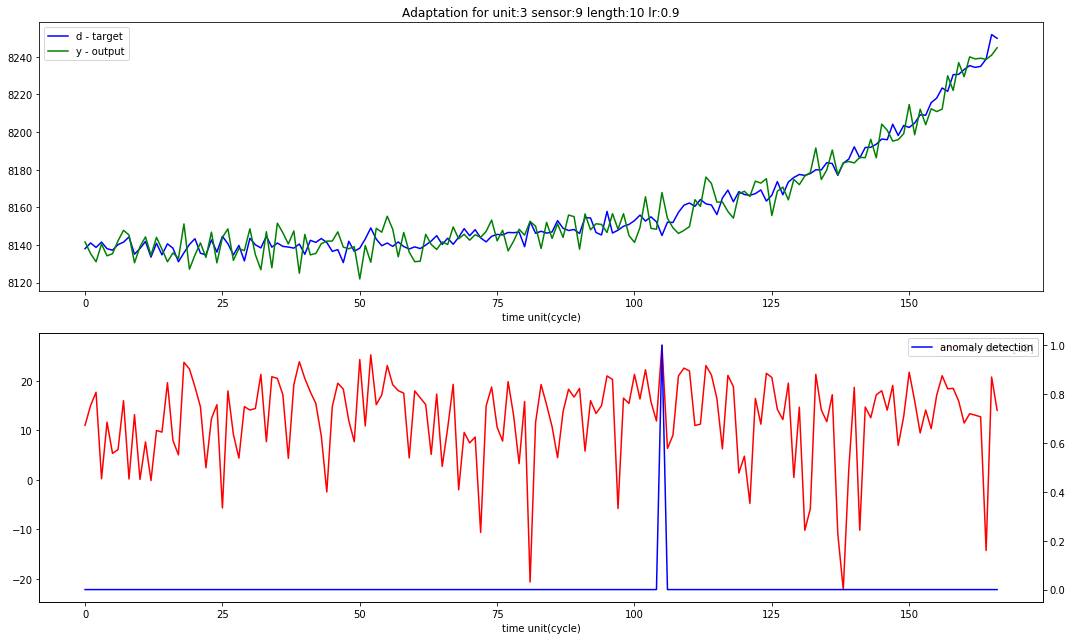

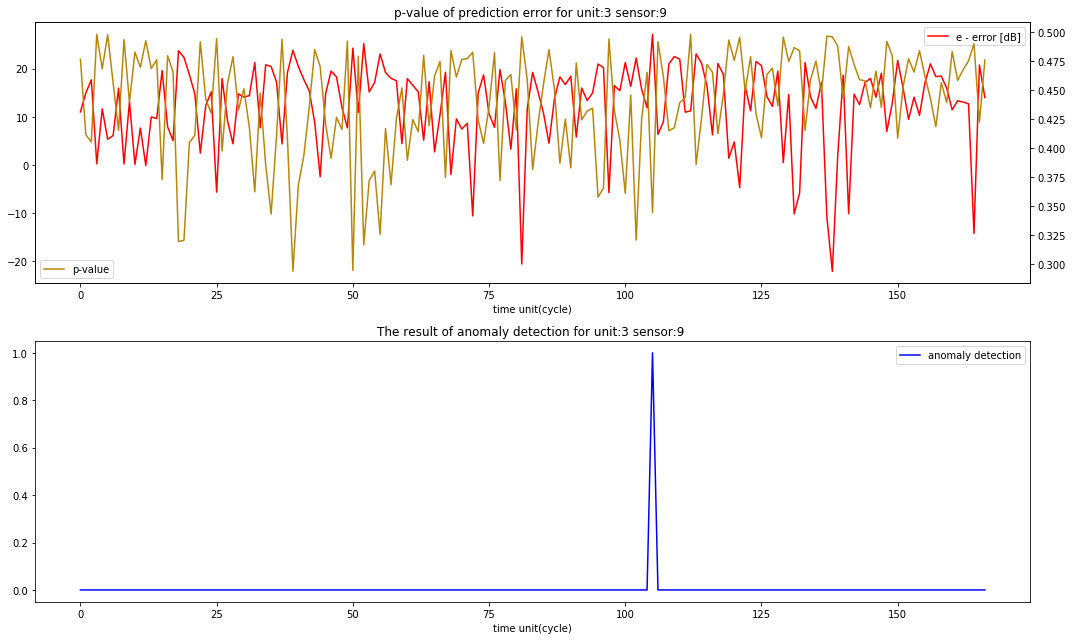

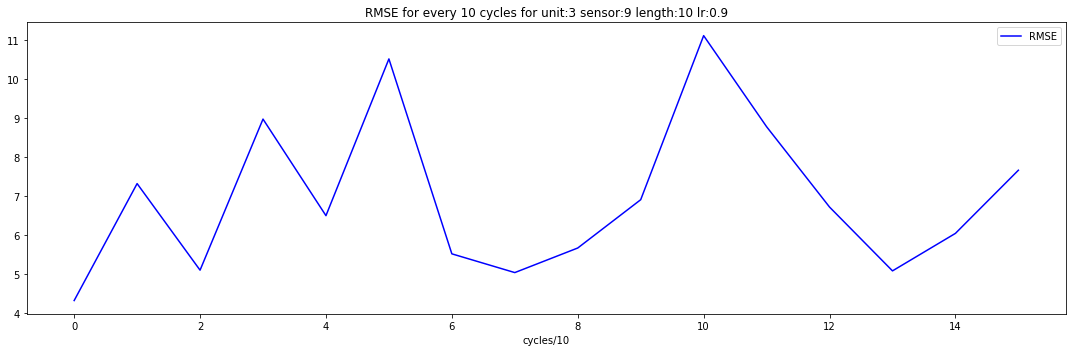

Initialized value of sensor 10 -  mu:[0.01805452], signma:[0.00989873], thold_ad:[16.36287776], thold_p:19.600000000000023
no anomaly detected
Initialized value of sensor 11 -  mu:[0.10272636], signma:[0.53411075], thold_ad:[8.02658842], thold_p:9.700000000000001
no anomaly detected
Initialized value of sensor 12 -  mu:[-0.07410163], signma:[0.04255919], thold_ad:[13.59282244], thold_p:16.300000000000015
no anomaly detected
Initialized value of sensor 13 -  mu:[-0.04827368], signma:[0.05384222], thold_ad:[9.06101209], thold_p:10.900000000000004
no anomaly detected
Initialized value of sensor 0 -  mu:[0.06185489], signma:[0.19003732], thold_ad:[11.25440028], thold_p:13.60000000000001
no anomaly detected
Initialized value of sensor 1 -  mu:[1.76258583], signma:[5.2297772], thold_ad:[5.18139037], thold_p:6.399999999999998
no anomaly detected
Initialized value of sensor 2 -  mu:[2.63417645], signma:[1.18137622], thold_ad:[26.98394782], thold_p:32.20000000000005
no anomaly detected
Initiali

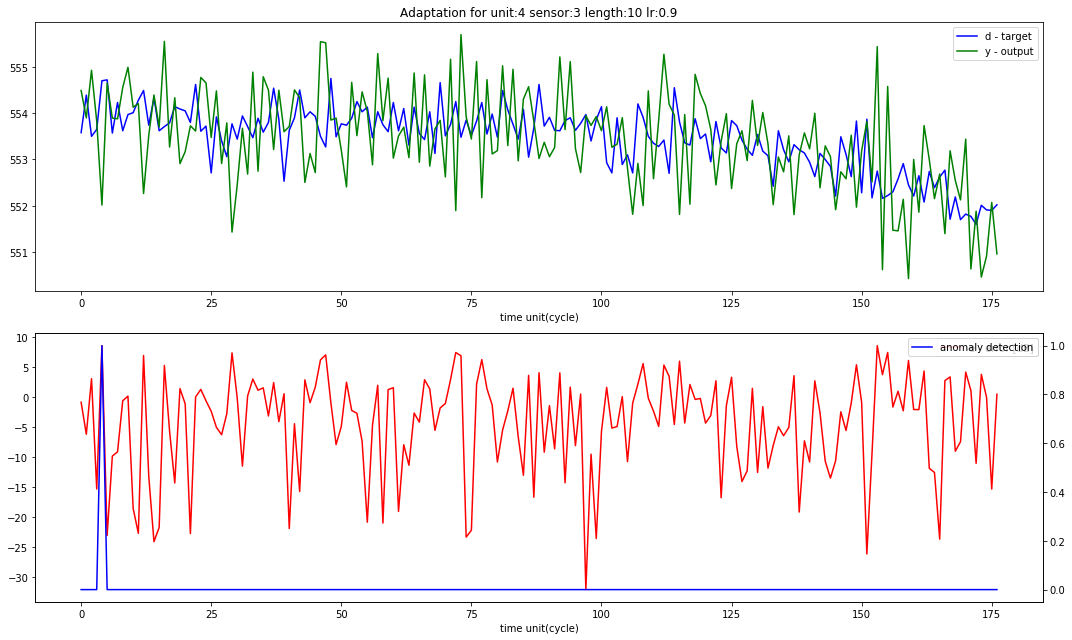

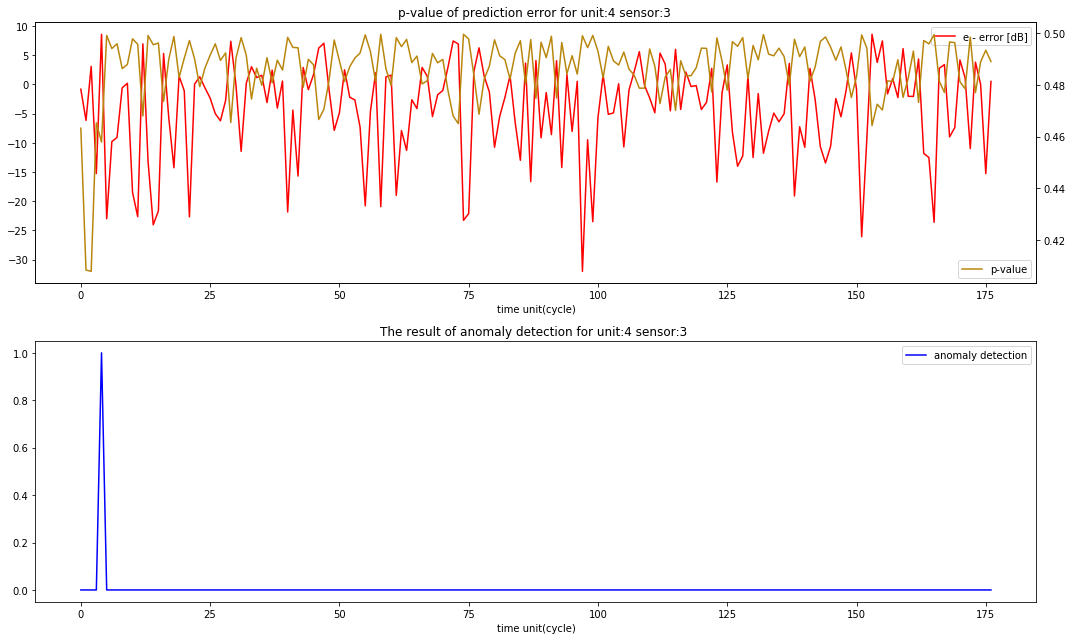

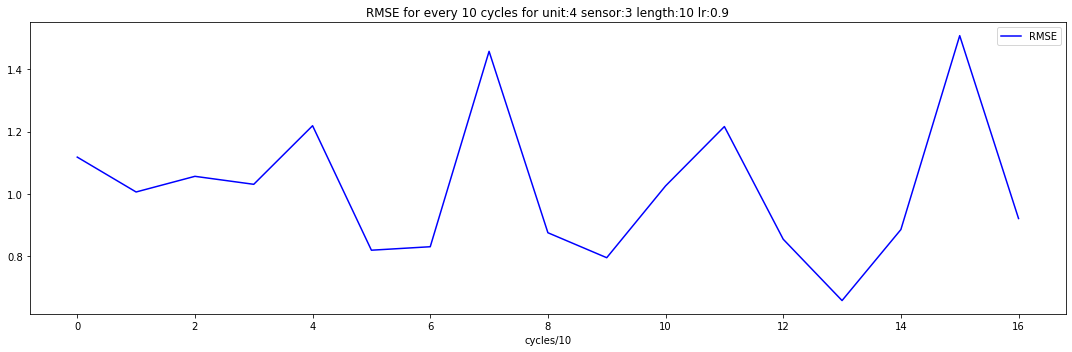

Initialized value of sensor 4 -  mu:[-0.01247182], signma:[0.0222525], thold_ad:[7.99177898], thold_p:9.700000000000001
no anomaly detected
Initialized value of sensor 5 -  mu:[-0.83298774], signma:[10.34124538], thold_ad:[2.42252514], thold_p:3.0999999999999996
no anomaly detected
Initialized value of sensor 6 -  mu:[-0.04526797], signma:[0.14161029], thold_ad:[5.57106582], thold_p:6.6999999999999975
no anomaly detected
Initialized value of sensor 7 -  mu:[0.00751537], signma:[0.21355119], thold_ad:[11.57621709], thold_p:13.900000000000011
no anomaly detected
Initialized value of sensor 8 -  mu:[-0.00963768], signma:[0.03406395], thold_ad:[4.30002167], thold_p:5.199999999999998
no anomaly detected
Initialized value of sensor 9 -  mu:[-0.15489771], signma:[7.43808381], thold_ad:[2.8647871], thold_p:3.6999999999999993
no anomaly detected
Initialized value of sensor 10 -  mu:[0.02436789], signma:[0.02455732], thold_ad:[4.51220854], thold_p:5.499999999999998
no anomaly detected
Initialize

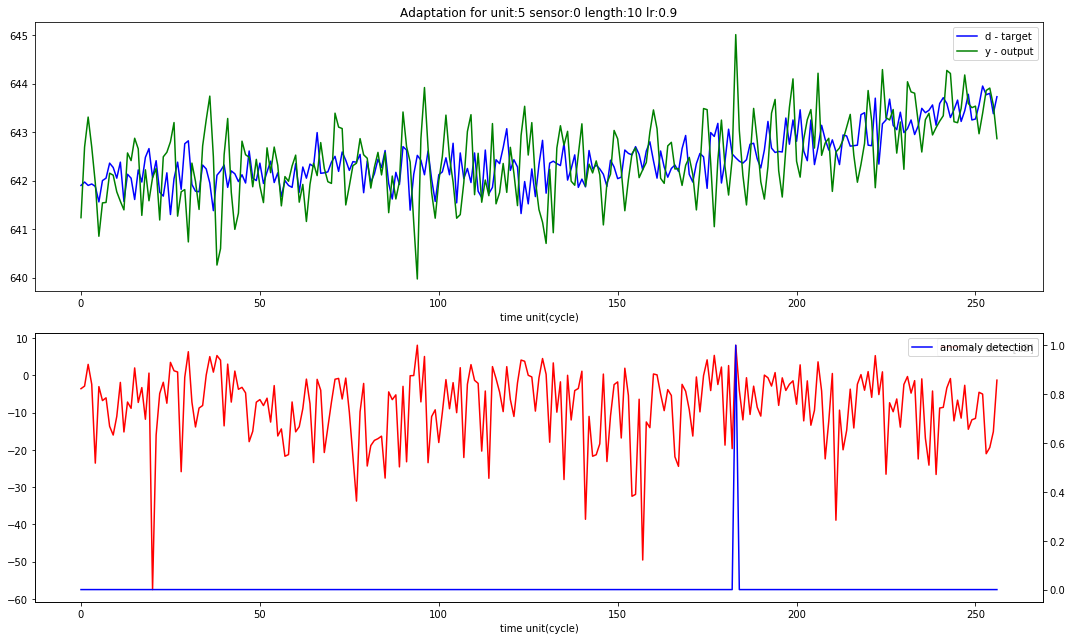

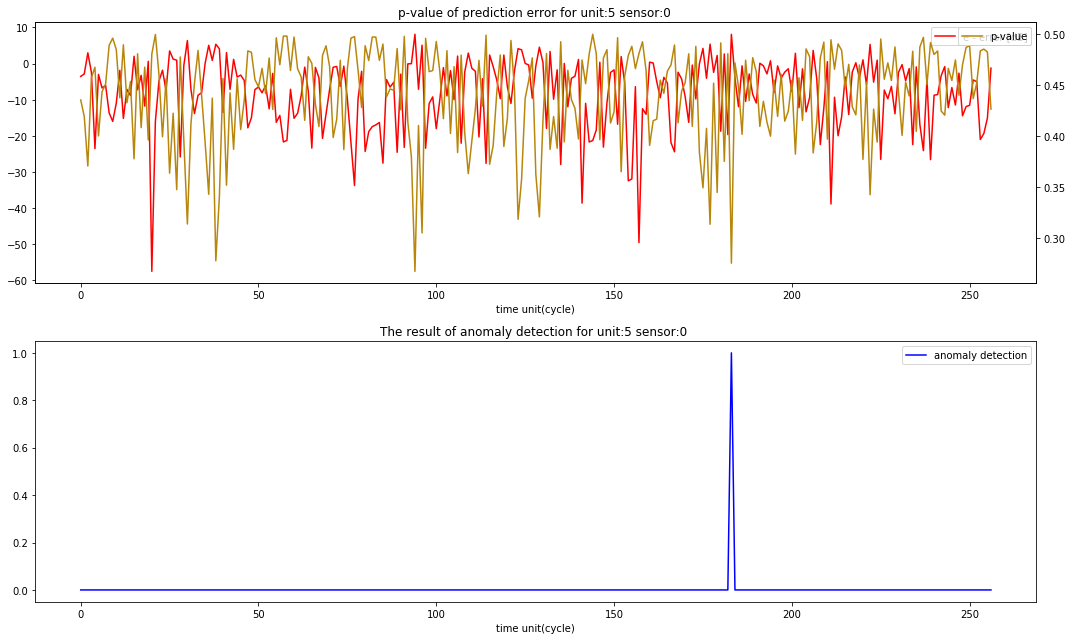

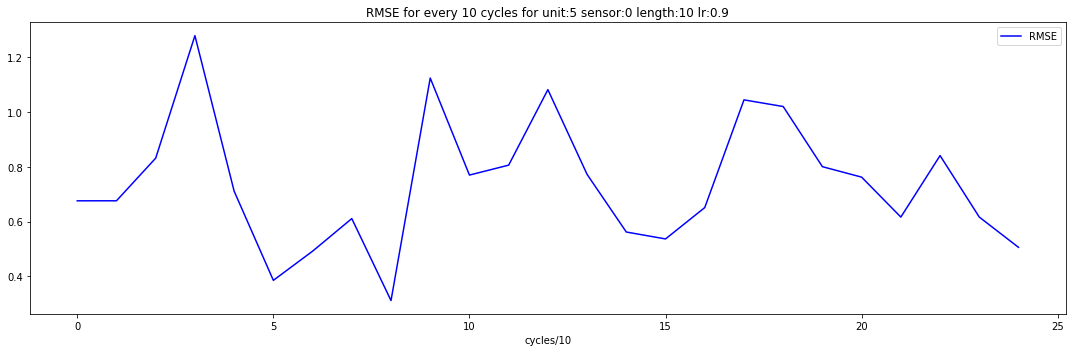

Initialized value of sensor 1 -  mu:[-0.93426243], signma:[7.15622694], thold_ad:[3.69199704], thold_p:4.599999999999999
no anomaly detected
Initialized value of sensor 2 -  mu:[0.72100396], signma:[2.93928032], thold_ad:[10.39962661], thold_p:12.400000000000007
no anomaly detected
Initialized value of sensor 3 -  mu:[-0.14862237], signma:[0.05342281], thold_ad:[61.62242012], thold_p:73.29999999999967


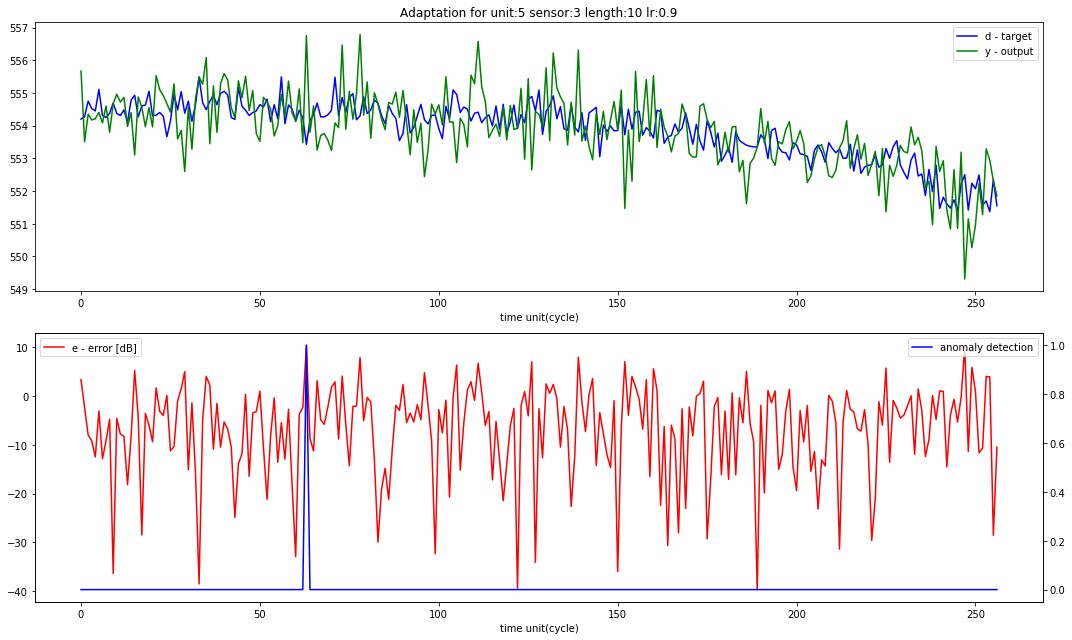

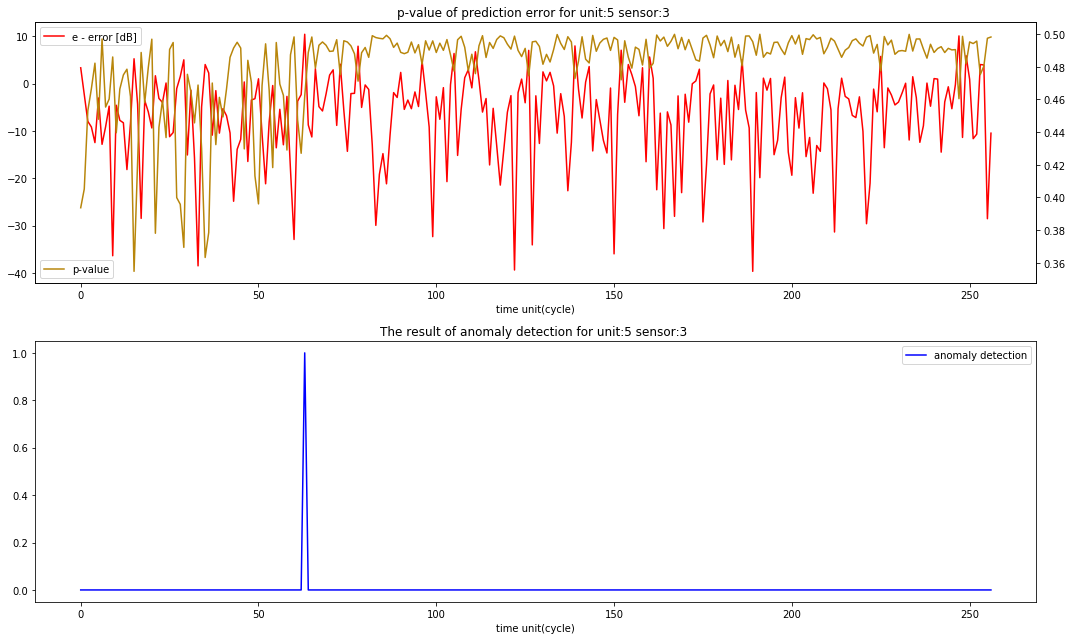

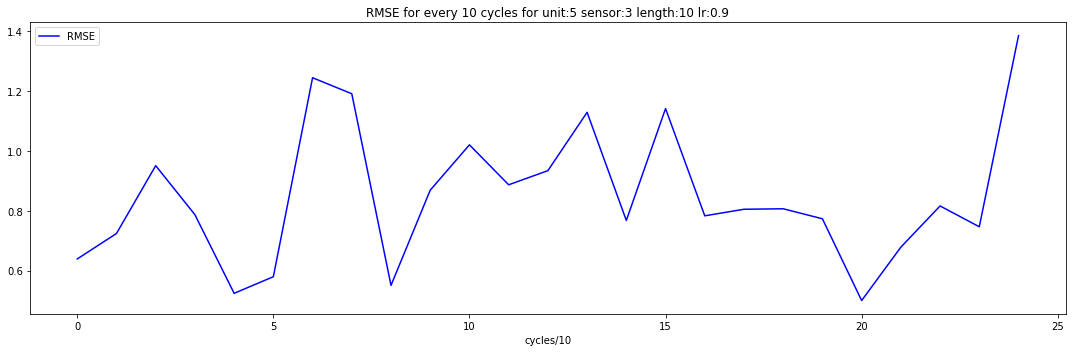

Initialized value of sensor 4 -  mu:[-0.01010357], signma:[0.08802241], thold_ad:[2.17308308], thold_p:2.8
no anomaly detected
Initialized value of sensor 5 -  mu:[-1.80996859], signma:[7.1079391], thold_ad:[4.10468699], thold_p:4.899999999999999
no anomaly detected
Initialized value of sensor 6 -  mu:[-0.0466627], signma:[0.01610304], thold_ad:[50.17162563], thold_p:59.79999999999979


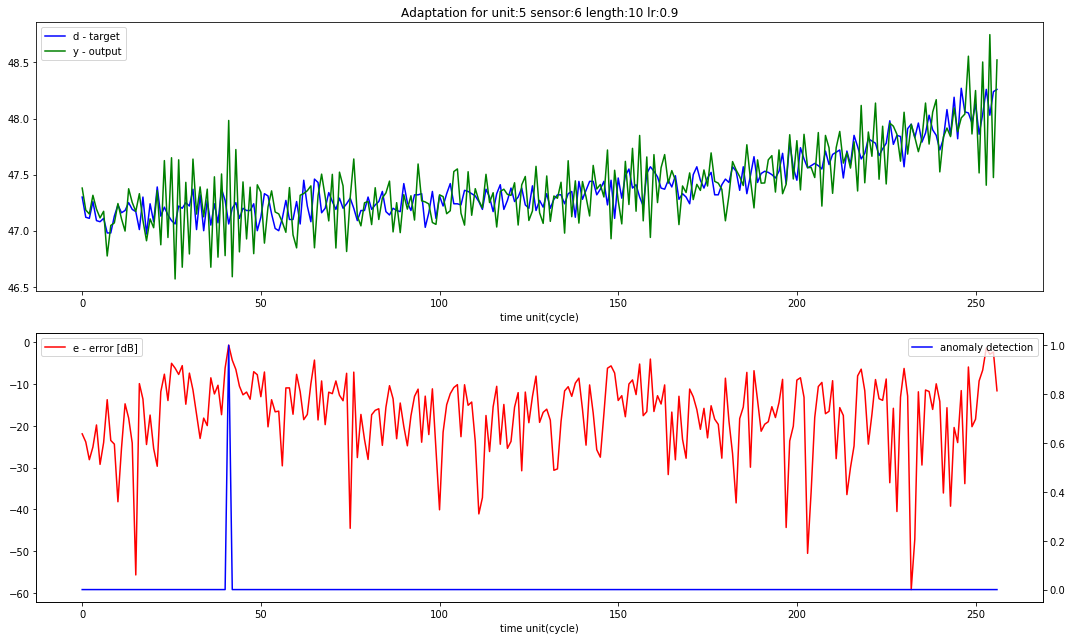

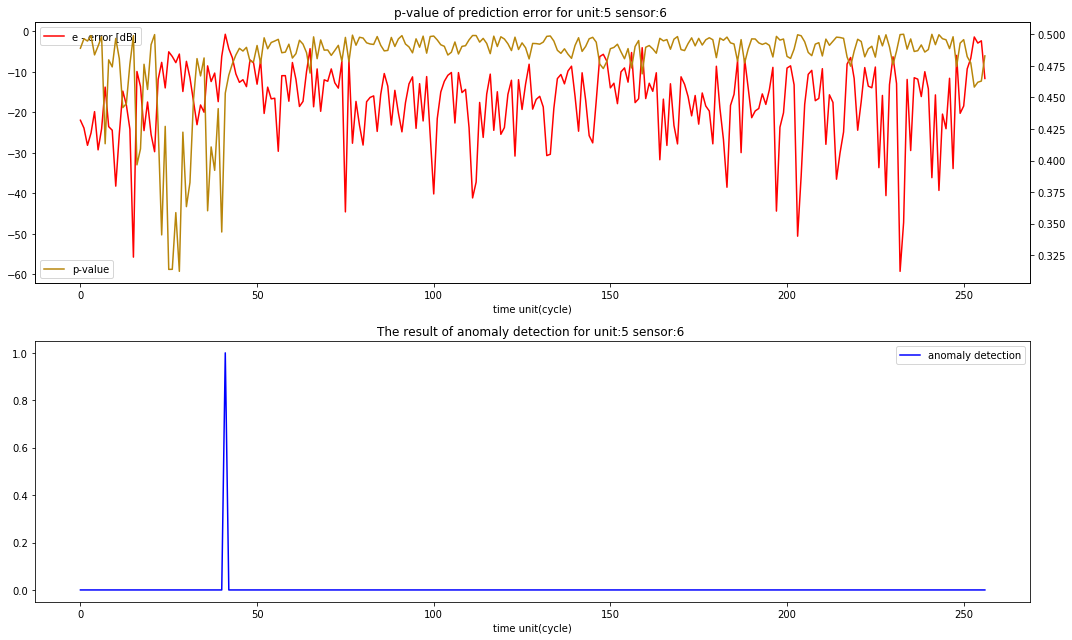

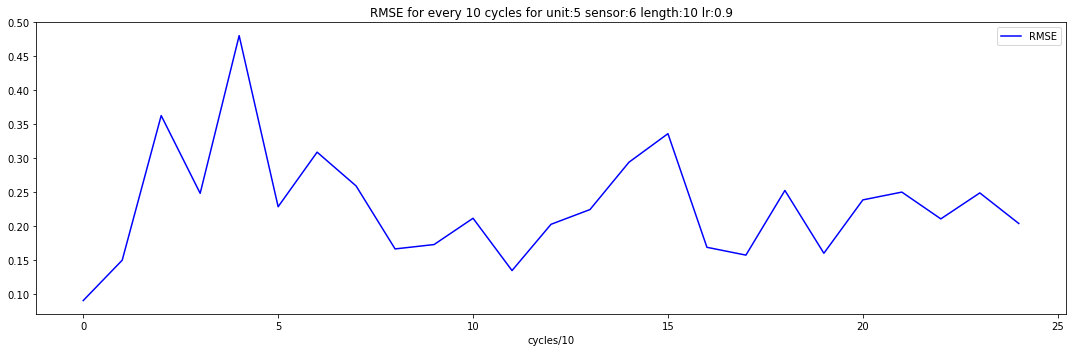

Initialized value of sensor 7 -  mu:[-0.0336212], signma:[0.01161844], thold_ad:[180.93113624], thold_p:215.20000000000246


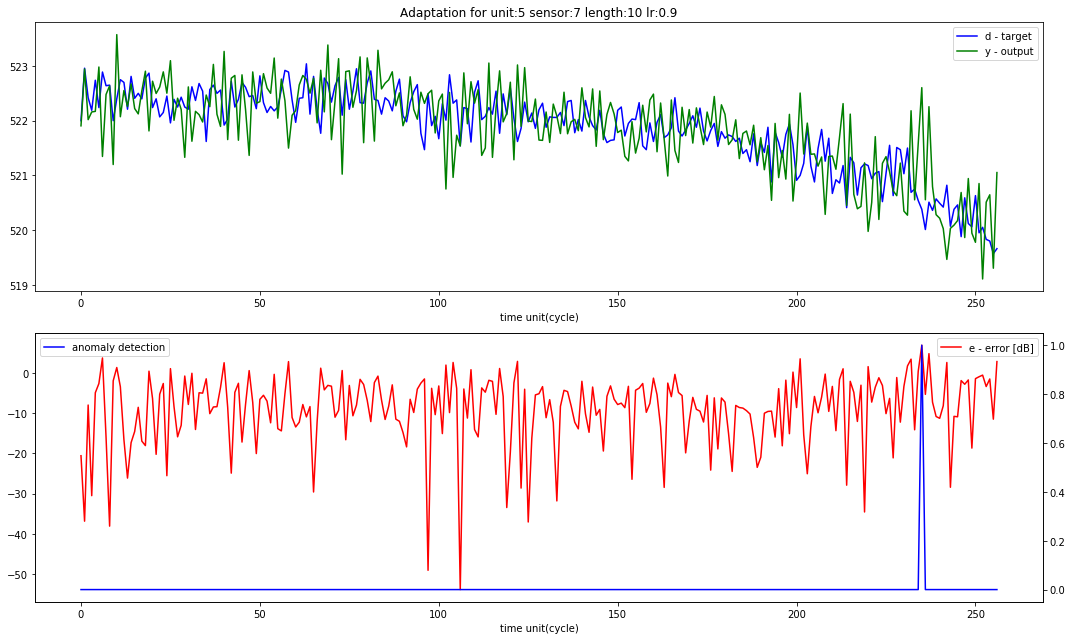

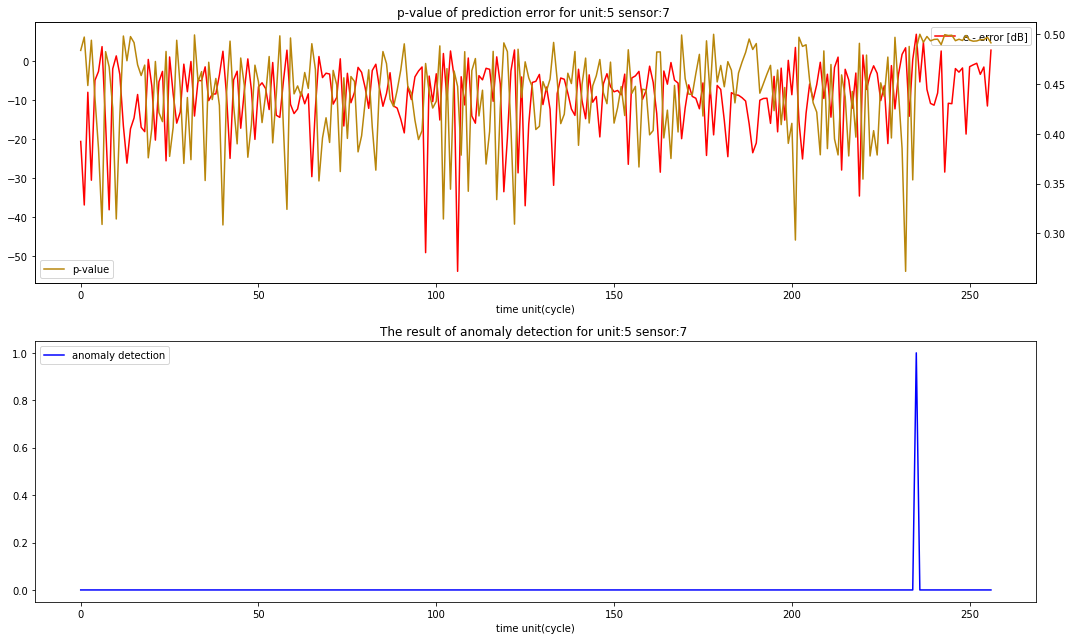

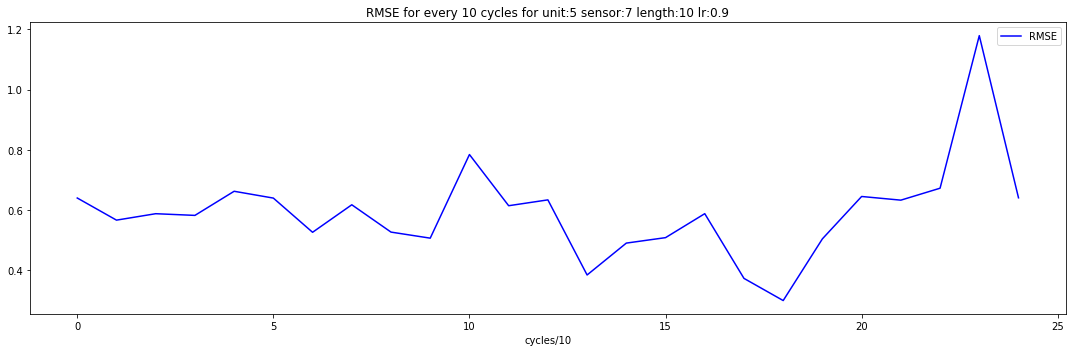

Initialized value of sensor 8 -  mu:[-0.01951471], signma:[0.04980513], thold_ad:[4.32919186], thold_p:5.199999999999998
no anomaly detected
Initialized value of sensor 9 -  mu:[-0.11638621], signma:[7.38672801], thold_ad:[3.28103581], thold_p:3.999999999999999
no anomaly detected
Initialized value of sensor 10 -  mu:[0.03177085], signma:[0.03374078], thold_ad:[3.74112011], thold_p:4.599999999999999
no anomaly detected
Initialized value of sensor 11 -  mu:[0.6380005], signma:[1.41106688], thold_ad:[4.79353132], thold_p:5.799999999999998
no anomaly detected
Initialized value of sensor 12 -  mu:[-0.0158194], signma:[0.0466735], thold_ad:[13.33136804], thold_p:16.000000000000014
no anomaly detected
Initialized value of sensor 13 -  mu:[-0.02016836], signma:[0.19507523], thold_ad:[2.06747088], thold_p:2.5


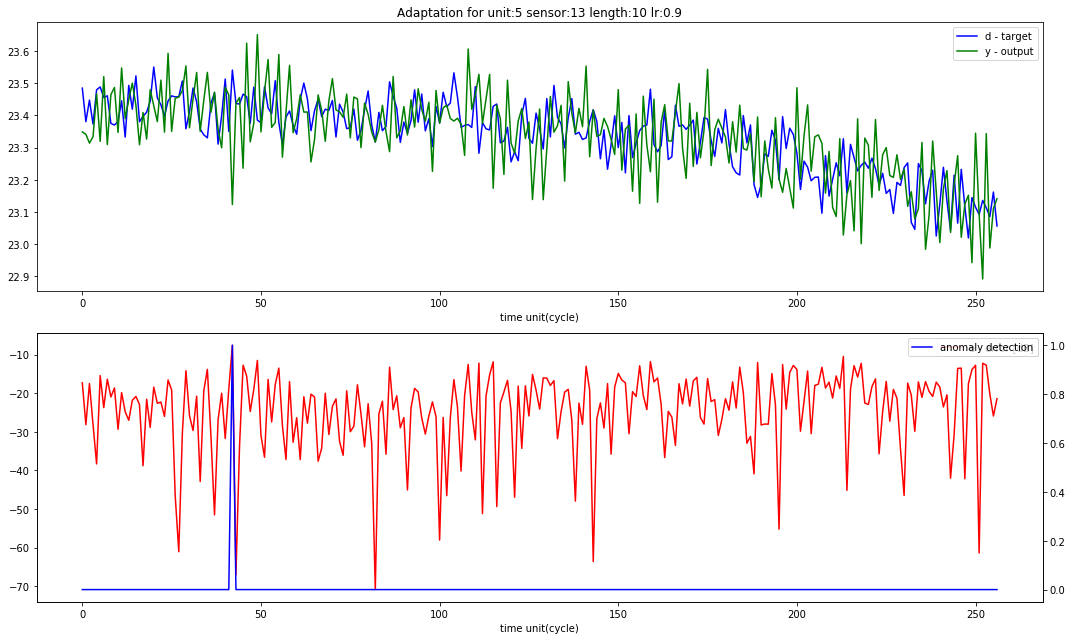

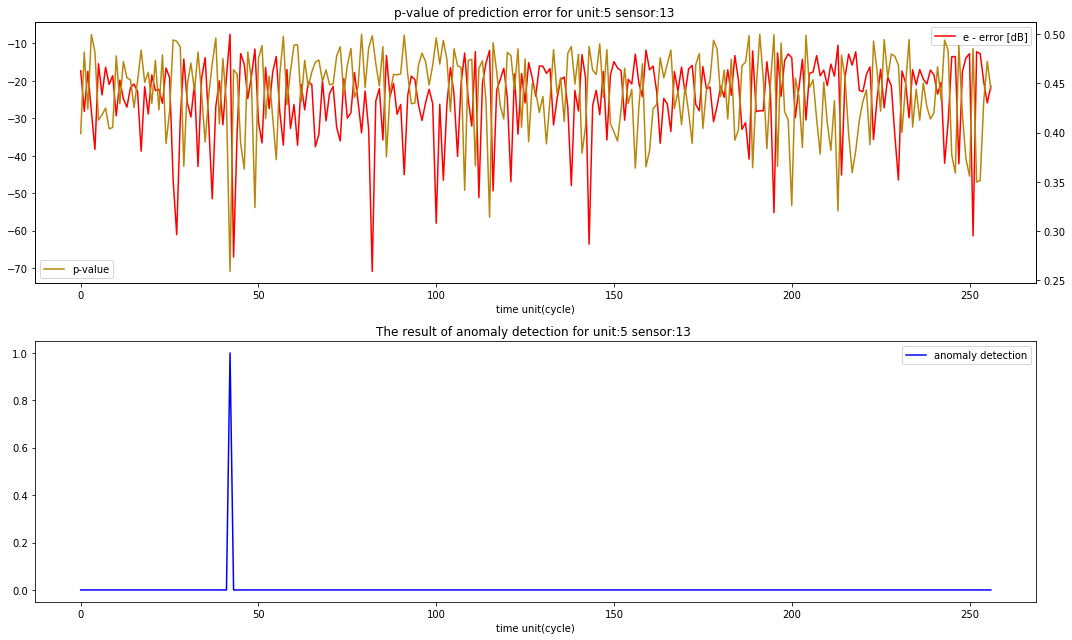

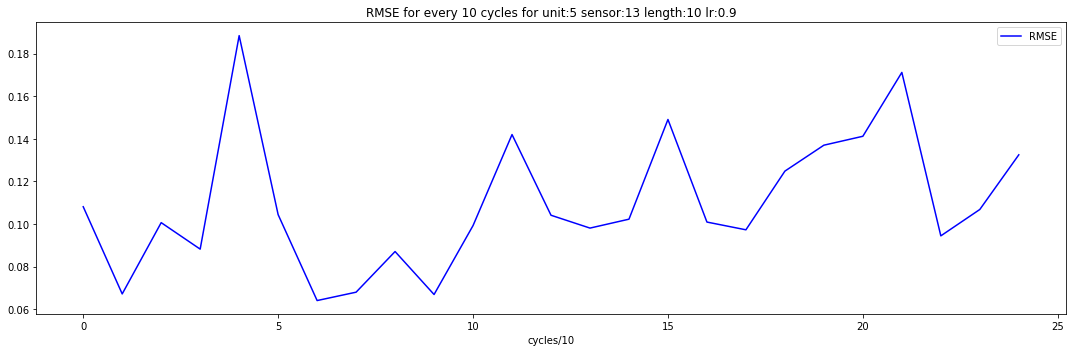

In [14]:
sequence_length = 10
pred_length = 1
lr = 0.9
# unit_id_idx = 96 # 1~100
sensor_idx = 14  # 0~13, sensor 2,3,4,7,8,9,11,12,13,14,15,17,20 and 21 in order

# RMSE of first n samples and last n samples
n = 10

p_err_u_list = []


### Initialize the parameters for anomaly detection 
anomaly = False
mu = 1
sigma = 1
lmbd_mu = 0.2
lmbd_sigma = 0.8
thold_ad = 0.1
thold_p = 0.1


for unit_id_idx in range(5):
    p_err_s_list = []
    unit_id_idx += 1
    for s_i in range(sensor_idx):
        
        anomaly = False
        mu = 1
        sigma = 1
        lmbd_mu = 0.2
        lmbd_sigma = 0.1
        thold_ad = 0.1
        thold_p = 0.1
        
            # pick the feature columns
        sensor_dataframe = train_FD001.drop(columns=['unit_nr','cycles','os_1','os_2','RUL'])
        sequence_cols = sensor_dataframe.columns.values.tolist()
    #     print (sequence_cols)

        # generator for the sequences
        # transform each id of the train dataset in a sequence
        seq_gen = (list(gen_sequence(train_FD001[train_FD001['unit_nr'] == id], sequence_length, sequence_cols))
                   for id in np.delete(train_FD001['unit_nr'].unique(),unit_id_idx-1))

        # generate sequences and convert to numpy array
        seq_array  = np.concatenate(list(seq_gen))
        # seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
#         print(seq_array[0])
    #     print(seq_array.shape)


        # generator for the sequences
        # transform each id of the train dataset in a sequence
        target_seq_gen = (list(gen_target(train_FD001[train_FD001['unit_nr'] == id], sequence_length, pred_length, sequence_cols))
                   for id in np.delete(train_FD001['unit_nr'].unique(),unit_id_idx-1))

        # print ("target_seq_gen", target_seq_gen)
        # generate sequences and convert to numpy array
        target_seq_array  = np.concatenate(list(target_seq_gen))
        # target_seq_array = np.concatenate(list(target_seq_gen)).astype(np.float32)
#         print(target_seq_array[0])
#         print(target_seq_array.shape)



        # generate RUL labels
        label_gen = [gen_labels(train_FD001[train_FD001['unit_nr'] == id], sequence_length, ['RUL'])
                     for id in np.delete(train_FD001['unit_nr'].unique(),unit_id_idx-1)]

        label_array = np.concatenate(label_gen).astype(np.float32)



        ### Prediction error estimation with RLS

        ## Check data shape (last instance of each unit is excluded)
    #     print ("other sensors input data shape: " , seq_array[:,:,0].shape)
    #     print ("other sensors target measurement shape: ", target_seq_array[:,:,0].shape)
    #     print ("RUL array shape: ", label_array.shape)

        ## Apadt model first
        ## An example how to filter data measured in real-time
        # these two function supplement your online measurment

        s2_input_array = seq_array[:,:,s_i]
        s2_target_array = target_seq_array[:,:,s_i]

        N = seq_array.shape[0]
        log_d = np.zeros(N)
        log_y = np.zeros(N)

        filt = pa.filters.FilterRLS(sequence_length, mu=lr)
        
        init_p_err_list = []
        
        
        for k in range(N-1):
            # measure input
    #         print ("k",k)
            x = s2_input_array[k]
#             print ("x",x)
        #     print (x.shape)
            # predict new value
            y = filt.predict(x)
            # do the important stuff with prediction output
            pass    
            # measure output
            d = s2_target_array[k]
#             print ("d", d)
#             print ("y", y)
            # update filter
            filt.adapt(d, x)
            # log values
            log_d[k] = d
            log_y[k] = y
            
            epsilon = d-y
            """
            Here, after computing prediction error for each sensor of other TTF(R2F) cycle, use those
            prediction erros to initinalize the parameters(factors) for anomaly detection 

            """
            #initialize mean and absolute deviation
            
            if k < 10 :
                pass
                
            elif k >= 10 and k < 30 :
                init_p_err_list.append(epsilon)
#                 print (init_p_err_list)
            
            # start from 'mean of first 10 samples', 'absolute deviation of a sample from this mean'
            elif k == 30:
#                 print ("it should be appear only 30")
                mu = np.mean(init_p_err_list)
                sigma = abs(init_p_err_list[int(k/2)] - mu)
            
            # half of overall sample is used for the first initial phase
            elif k > 30 and k < int((N-1)/2) :
                mu, sigma = InitPhaseOne (epsilon, mu, sigma, lmbd_mu, lmbd_sigma)
            
            # remaining half would be used for the second phase
            else :
#                 print ("it is else statement")
                mu,sigma, thold_ad = InitPhaseTwo (epsilon, mu, sigma, lmbd_mu, lmbd_sigma, thold_ad)
                thold_p = InitPhasePvalue (epsilon, mu, sigma, thold_p, conf_lv = 0.20)
#             print ("epsilon:%s, mu:%s, signma:%s, thold_ad:%s, thold_p:%s" %(epsilon, mu,sigma, thold_ad, thold_p))

        print ("Initialized value of sensor %s -  mu:%s, signma:%s, thold_ad:%s, thold_p:%s" %(s_i, mu,sigma, thold_ad, thold_p))    
        

        ## sequence of time series data and target measurement values for selected machine (unit_id_idx)
        seq_gen_m_id = (list(gen_sequence(train_FD001[train_FD001['unit_nr'] == unit_id_idx], sequence_length, sequence_cols))
                   )

        # generate sequences and convert to numpy array
        seq_array_m_id  = np.array(list(seq_gen_m_id))
        # seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
        # print(seq_array_m_id)
    #     print(seq_array_m_id.shape)



        # generator for the sequences
        # transform each id of the train dataset in a sequence
        target_seq_gen_m_id = (list(gen_target(train_FD001[train_FD001['unit_nr'] == unit_id_idx], sequence_length, pred_length, sequence_cols))
                   )

        # print ("target_seq_gen", target_seq_gen)
        # generate sequences and convert to numpy array
        target_seq_array_m_id  = np.array(list(target_seq_gen_m_id))
        # target_seq_array = np.concatenate(list(target_seq_gen)).astype(np.float32)
        # print(target_seq_array_m_id)
    #     print(target_seq_array_m_id.shape)


        #only sensor_02

        s2_input_m_id = seq_array_m_id[:,:,s_i]
        s2_target_m_id = target_seq_array_m_id[:,:,s_i]


        N = s2_input_m_id.shape[0]
        log_d = np.zeros(N-1)
        log_y = np.zeros(N-1)
        epsilon_array = np.zeros(N-1)
        anomaly_array = np.zeros(N-1)
        p_value_array = np.zeros(N-1)
        
        for k in range(N-1):
            # measure input
    #         print ("k",k)
            x = s2_input_m_id[k]
#             print ("x", x)
        #     print (x.shape)
            # predict new value
            y = filt.predict(x)
            # do the important stuff with prediction output

            # measure output
            d = s2_target_m_id[k]
#             print ("d", d)
#             print ("y", y)
            # update filter
            filt.adapt(d, x)

            epsilon = d-y
            """
            Use Initilized paramters above to compute anomaly and p value,
            compute every loop( online)
            anomaly(True/False) and p-value will be assigned into array/list and display
            
            """
            mu, sigma , anomaly, p_value = Detection (epsilon, mu, sigma, lmbd_mu, lmbd_sigma, thold_ad, thold_p, anomaly=False)
#             print ("online update - epsilon:%s,  mu:%s , sigma:%s" %(epsilon, mu,sigma))
#             print ("detection results - anaomaly:%s , p_value:%s" %(anomaly, p_value))
            
            # log values
            log_d[k] = d
            log_y[k] = y
            # save prediction error to array for each sensor
            epsilon_array[k] = epsilon
            anomaly_array[k] = anomaly
            p_value_array[k] = p_value
            
        
        # An array of each sensor is appended to list
        p_err_s_list.append(epsilon_array)


        
        if np.any(anomaly_array) == True :
            ### show results
            plt.figure(figsize=(15,9))
            plt.subplot(211);plt.title("Adaptation for unit:%s sensor:%s length:%s lr:%s" %(unit_id_idx,s_i, sequence_length, lr));plt.xlabel("time unit(cycle)")
            plt.plot(log_d,"b", label="d - target")
            plt.plot(log_y,"g", label="y - output");plt.legend()
            ax1 = plt.subplot(212)
            ax1.set_xlabel("time unit(cycle)")
            ax2 = ax1.twinx()
            ax1.plot(10*np.log10((log_d-log_y)**2),"r", label="e - error [dB]");ax1.legend()
            ax2.plot(anomaly_array,"b", label="anomaly detection");ax2.legend()
            plt.legend(); plt.tight_layout(); plt.show()




            ## Plots for the anomaly detection
            plt.figure(figsize=(15,9))
            ax1 = plt.subplot(211);plt.title("p-value of prediction error for unit:%s sensor:%s " %(unit_id_idx,s_i));plt.xlabel("time unit(cycle)")
            ax1.set_xlabel("time unit(cycle)")
            ax2 = ax1.twinx()
            ax1.plot(10*np.log10((log_d-log_y)**2),"r", label="e - error [dB]");ax1.legend()      
            ax2.plot(p_value_array,"darkgoldenrod", label="p-value");ax2.legend()        
            plt.subplot(212);plt.title("The result of anomaly detection for unit:%s sensor:%s " %(unit_id_idx,s_i));plt.xlabel("time unit(cycle)")
            plt.plot(anomaly_array,"b", label="anomaly detection");plt.legend()
            plt.legend(); plt.tight_layout(); plt.show()    



            ## Numerical evaluation


            y_actual = log_d
            y_predicted = log_y

            first_n_rmse = sqrt(mean_squared_error(y_actual[:n], y_predicted[:n]))
            last_n_rmse = sqrt(mean_squared_error(y_actual[-n:], y_predicted[-n:]))

        #     print ("first %s cycles RMSE of prediction: %s" %(n,first_n_rmse))
        #     print ("last %s cycles RMSE of prediction: %s" %(n,last_n_rmse))





            '''
            RMSE evaluation with fixed window size n
            '''

            # s2_input_m_id = seq_array_m_id[:,:,sensor_idx]
            # s2_target_m_id = target_seq_array_m_id[:,:,sensor_idx]
            # x = s2_input_m_id
            # d = s2_target_m_id

            # y, e, w = filt.run(d, x)
            # y_actual = d
            # y_predicted = y





        #     print (len(y_predicted))
        #     print (int(len(y_predicted)/n))
            rmse_list = []
            for iter in range(int(len(y_predicted)/n)) :
                rmse_temp = sqrt(mean_squared_error(y_actual[n*iter:n*(iter+1)], y_predicted[n*iter:n*(iter+1)]))
                rmse_list.append(rmse_temp)



        #     print (rmse_list)

            ### show results
            fig_rmse = plt.figure(figsize=(15,5))
            plt.plot(rmse_list,"b", label="RMSE")
            plt.xlabel("cycles/%s" %n)
            plt.title("RMSE for every %s cycles for unit:%s sensor:%s length:%s lr:%s" %(n,unit_id_idx,s_i, sequence_length, lr))
            plt.legend(); plt.tight_layout(); plt.show()
            fig_rmse.savefig("plots/rmse_u_%s_s_%s_len_%s_lr_%s.png" %(unit_id_idx,s_i,sequence_length, lr))


        else:
            print ("no anomaly detected")

        
        
    ## list of prediction error (of all sensor per unit) is appended to final list
    

    p_err_u_list.append(p_err_s_list)

In [ ]:

'''
p_err_u_list[unit idx][sensor idx][time stamp]

'''



In [ ]:
epsilon = 2.3
mu = -1
sigma = 0

if epsilon > mu :
    p_value = stats.norm.sf(epsilon, mu, sigma) #p-value ad given normal dist
    
else :
    p_value = stats.norm.cdf(epsilon, mu, sigma) #p-value ad given normal dist
print (p_value)


# p_distr = stats.norm.rvs(loc = mu, scale = sigma, size=10000)
# tset, p_value = ttest_1samp(p_distr, epsilon)
# print ('p_value: %2.10f' %p_value)

stats.norm.ppf(0.05, loc = mu, scale = sigma)

# stats.norm.interval(alpha=0.5, loc = mu, scale = sigma)